In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Found 5 CSV files


Loading datasets: 100%|██████████| 5/5 [00:00<00:00, 249.63it/s]


Dataset sizes:
Total samples: 5983
Train: 4188 (70.0%)
Validation: 897 (15.0%)
Test: 898 (15.0%)

Visualizing sample datapoints from training set...


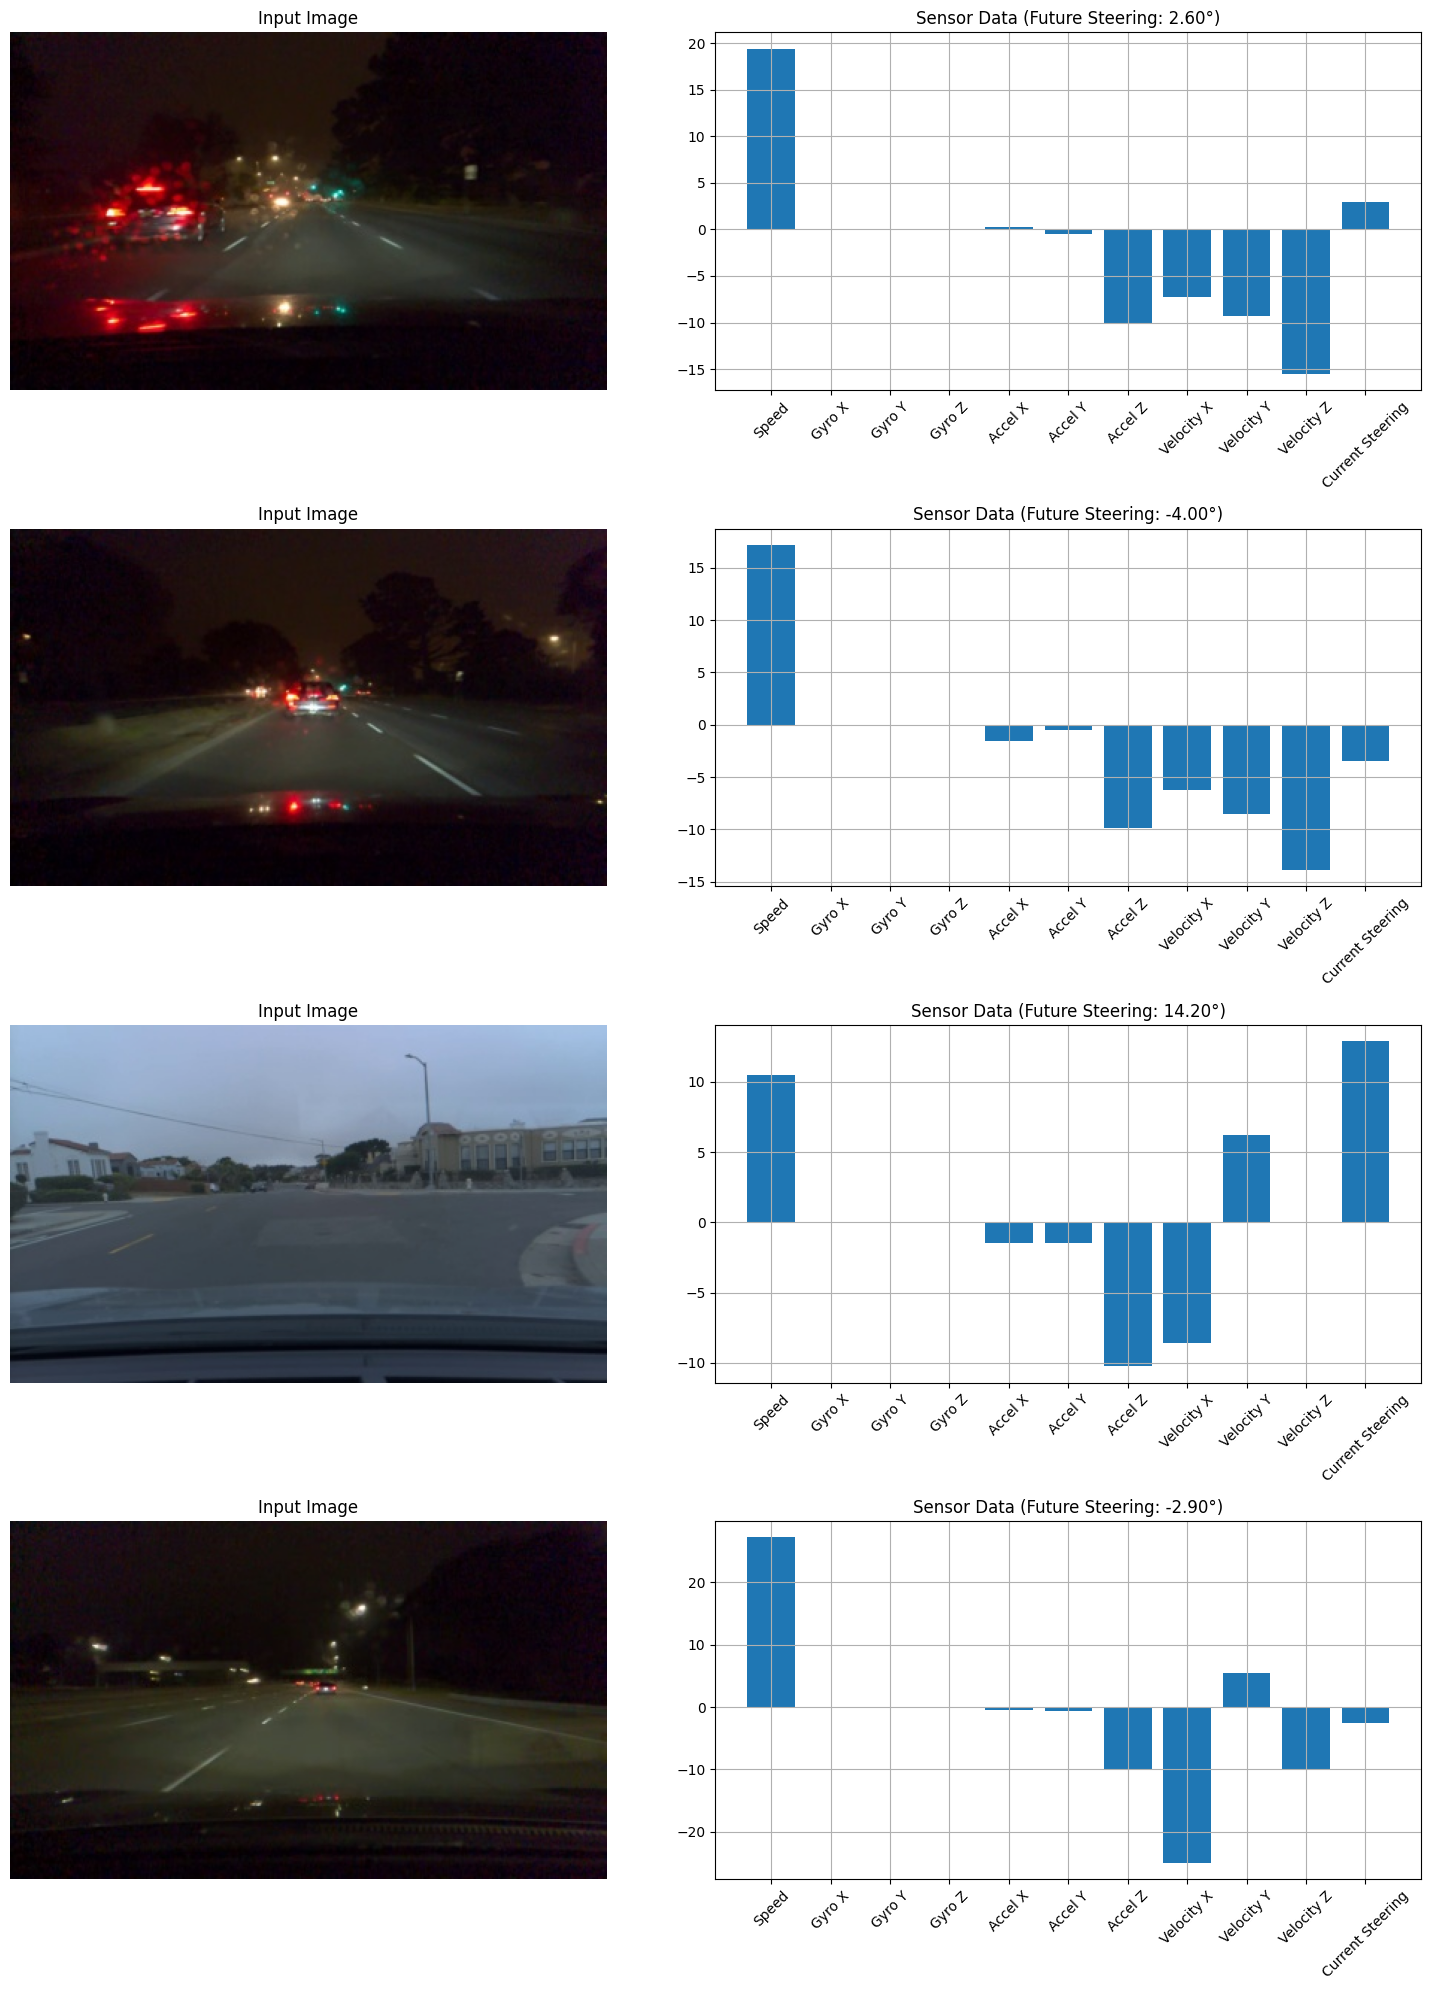

In [2]:
import glob
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define base directory paths
DATA_DIR = 'data_synced'  # Directory containing processed CSV files and frame folders

class DrivingDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        # Load the CSV data
        self.data = pd.read_csv(csv_file)
        
        # Get frames directory path from CSV filename
        filename = os.path.basename(csv_file)
        self.frames_dir = os.path.join(DATA_DIR, f"{filename[:-4]}_frames")
        
        # Verify frames directory exists
        if not os.path.exists(self.frames_dir):
            raise FileNotFoundError(f"Frames directory not found: {self.frames_dir}")
        
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get frame index from data
        frame_idx = int(self.data.iloc[idx]['frame_idx'])
        
        # Load frame image
        frame_path = os.path.join(self.frames_dir, f"{frame_idx}.jpg")
        frame = Image.open(frame_path).convert('RGB')
        
        if self.transform:
            frame = self.transform(frame)
        
        row = self.data.iloc[idx]
        
        # Get current sensor data (inputs)
        speed_value = float(row['speed'].strip('[]') if isinstance(row['speed'], str) else row['speed'])
        
        current_data = torch.tensor([
            speed_value,
            row['gyro_x'], row['gyro_y'], row['gyro_z'],
            row['accel_x'], row['accel_y'], row['accel_z'],
            row['velocity_x'], row['velocity_y'], row['velocity_z'],
            row['current_steering'],
        ], dtype=torch.float32)
        
        # Get future steering angle (target)
        target = torch.tensor(row['future_steering'], dtype=torch.float32)
        
        return frame, current_data, target

def visualize_sample_datapoints(dataset, num_samples=4):
    """
    Visualize a few sample datapoints from the dataset to verify format
    """
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        # Get a random sample
        idx = np.random.randint(len(dataset))
        image, sensor_data, target = dataset[idx]
        
        # Convert image tensor back to displayable format
        img = image.numpy().transpose(1, 2, 0)
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Plot image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')
        
        # Create sensor data visualization
        sensor_labels = [
            'Speed', 
            'Gyro X', 'Gyro Y', 'Gyro Z',
            'Accel X', 'Accel Y', 'Accel Z',
            'Velocity X', 'Velocity Y', 'Velocity Z',
            'Current Steering'
        ]
        
        # Plot sensor data as a bar chart
        axes[i, 1].bar(sensor_labels, sensor_data.numpy())
        axes[i, 1].set_title(f'Sensor Data (Future Steering: {target:.2f}°)')
        axes[i, 1].tick_params(axis='x', rotation=45)
        axes[i, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Get list of all CSV files in data_synced
csv_files = [f for f in glob.glob('data_synced/*.csv') if 'combined_dataset.csv' not in f]
print(f"Found {len(csv_files)} CSV files")

# Create datasets for each segment
datasets = []
for csv_file in tqdm(csv_files, desc="Loading datasets"):
    try:
        dataset = DrivingDataset(csv_file)
        datasets.append(dataset)
    except Exception as e:
        print(f"Error loading {csv_file}: {str(e)}")
        continue

if not datasets:
    raise RuntimeError("No datasets were successfully loaded!")

# Combine all datasets
full_dataset = ConcatDataset(datasets)
total_size = len(full_dataset)

# Split dataset into train, validation, and test sets (70%, 15%, 15%)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

print(f"\nDataset sizes:")
print(f"Total samples: {total_size}")
print(f"Train: {len(train_dataset)} ({len(train_dataset)/total_size*100:.1f}%)")
print(f"Validation: {len(val_dataset)} ({len(val_dataset)/total_size*100:.1f}%)")
print(f"Test: {len(test_dataset)} ({len(test_dataset)/total_size*100:.1f}%)")

# Create data loaders with no workers for simplicity
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# Visualize some samples to verify data format
print("\nVisualizing sample datapoints from training set...")
visualize_sample_datapoints(train_dataset)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
    
class SteeringAngleCNN(nn.Module):
    """
    CNN model for predicting future steering angles (t+200ms) from current dashcam images and sensor data.
    Based on NVIDIA's PilotNet architecture with additional sensor inputs.
    """
    def __init__(self):
        super(SteeringAngleCNN, self).__init__()

        # Number of sensor inputs (all current data)
        # speed (1), gyro(3), accel(3), velocity(3), current_steering(1) = 11
        self.sensor_input_size = 11

        # Convolutional layers for image processing
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(24),

            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(36),

            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(48),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        # Sensor processing layers
        self.sensor_layers = nn.Sequential(
            nn.Linear(self.sensor_input_size, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2)
        )

        # Placeholder for combined layers (will update in _calculate_conv_output_size)
        self.combined_layers = nn.Sequential(
            nn.Linear(1, 128),  # Placeholder
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 1)  # Predicting future steering angle
        )

        # Calculate the correct input size for combined layers
        self._calculate_conv_output_size()

    def _calculate_conv_output_size(self):
        """Calculate the size of the flattened features after convolution layers"""
        x = torch.zeros(1, 3, 240, 400)
        x = self.conv_layers(x)
        conv_flat_size = x.numel() // x.size(0)

        # Update the first linear layer in combined_layers
        combined_input_size = conv_flat_size + 64  # 64 is from sensor_layers output
        self.combined_layers[0] = nn.Linear(combined_input_size, 128)

        print(f"Calculated convolutional output size: {x.size()}")
        print(f"Flattened conv features size: {conv_flat_size}")
        print(f"Combined input size: {combined_input_size}")

    def forward(self, image, sensor_data):
        """
        Forward pass through the network.
        image: Tensor of shape (B, 3, H, W)
        sensor_data: Tensor of shape (B, sensor_input_size)
        Returns: Predicted steering angle at t+200ms
        """
        # Process image through CNN
        x_img = self.conv_layers(image)
        x_img = x_img.view(x_img.size(0), -1)  # Flatten CNN features

        # Process sensor data
        x_sensor = self.sensor_layers(sensor_data)

        # Combine image and sensor features
        x_combined = torch.cat([x_img, x_sensor], dim=1)
        
        # Predict future steering angle
        future_steering = self.combined_layers(x_combined)
        return future_steering

In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    """
    Train the model with early stopping.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Add this before training starts
    print("\nGPU Information:")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name()}")
        print(f"Device memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    model.to(device)
    print(f"Training on {device}")

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Use tqdm for progress bar
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for images, sensor_data, targets in pbar:
                images = images.to(device)
                sensor_data = sensor_data.to(device)
                targets = targets.to(device).view(-1, 1)  # Future steering angle

                optimizer.zero_grad()
                outputs = model(images, sensor_data)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                pbar.set_postfix({'loss': loss.item()})

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0

        with torch.no_grad():
            for images, sensor_data, targets in val_loader:
                images = images.to(device)
                sensor_data = sensor_data.to(device)
                targets = targets.to(device).view(-1, 1)

                outputs = model(images, sensor_data)
                loss = criterion(outputs, targets)
                running_loss += loss.item() * images.size(0)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, train_losses, val_losses

In [5]:
def test_model(model, test_loader):
    """
    Test the model with steering-specific metrics for future steering angle prediction.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, sensor_data, target_angle in test_loader:  # Now unpacking three values
            images = images.to(device)
            sensor_data = sensor_data.to(device)
            target_angle = target_angle.to(device).view(-1, 1)  # Future steering angle

            outputs = model(images, sensor_data)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(target_angle.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Calculate metrics
    mse = np.mean((all_preds - all_targets) ** 2)
    mae = np.mean(np.abs(all_preds - all_targets))
    within_1_deg = np.mean(np.abs(all_preds - all_targets) < 1.0) * 100
    within_3_deg = np.mean(np.abs(all_preds - all_targets) < 3.0) * 100
    within_5_deg = np.mean(np.abs(all_preds - all_targets) < 5.0) * 100

    print("\nTest Results (Predicting Steering Angle at t+200ms):")
    print(f"MSE: {mse:.4f} degrees²")
    print(f"MAE: {mae:.4f} degrees")
    print(f"Predictions within 1°: {within_1_deg:.1f}%")
    print(f"Predictions within 3°: {within_3_deg:.1f}%")
    print(f"Predictions within 5°: {within_5_deg:.1f}%")

    # Visualizations
    plt.figure(figsize=(15, 5))

    # Prediction vs Ground Truth
    plt.subplot(1, 2, 1)
    plt.plot(all_targets[:100], label='Future Ground Truth')
    plt.plot(all_preds[:100], label='Predicted Future')
    plt.xlabel('Sample')
    plt.ylabel('Steering Angle (degrees)')
    plt.title('Predicted vs Actual Future Steering Angles')
    plt.legend()

    # Correlation plot
    plt.subplot(1, 2, 2)
    plt.scatter(all_targets, all_preds, alpha=0.1)
    plt.plot([-45, 45], [-45, 45], 'r--')
    plt.xlabel('Actual Future Steering Angle (degrees)')
    plt.ylabel('Predicted Future Steering Angle (degrees)')
    plt.title('Prediction Correlation (t+200ms)')

    plt.tight_layout()
    plt.show()

Calculated convolutional output size: torch.Size([1, 64, 3, 8])
Flattened conv features size: 1536
Combined input size: 1600

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 66/66 [00:05<00:00, 12.86it/s, loss=28.2]


Epoch 1: Train Loss: 37.2712, Val Loss: 27.1911


Epoch 2/50: 100%|██████████| 66/66 [00:04<00:00, 13.93it/s, loss=14]  


Epoch 2: Train Loss: 23.2470, Val Loss: 16.7649


Epoch 3/50: 100%|██████████| 66/66 [00:04<00:00, 14.11it/s, loss=13.8]


Epoch 3: Train Loss: 16.3820, Val Loss: 12.2748


Epoch 4/50: 100%|██████████| 66/66 [00:04<00:00, 13.87it/s, loss=5.56]


Epoch 4: Train Loss: 12.8466, Val Loss: 9.6211


Epoch 5/50: 100%|██████████| 66/66 [00:04<00:00, 14.10it/s, loss=22.1]


Epoch 5: Train Loss: 10.4783, Val Loss: 8.9774


Epoch 6/50: 100%|██████████| 66/66 [00:04<00:00, 13.81it/s, loss=2.67]


Epoch 6: Train Loss: 8.7762, Val Loss: 6.3208


Epoch 7/50: 100%|██████████| 66/66 [00:04<00:00, 14.00it/s, loss=7.02]


Epoch 7: Train Loss: 7.6996, Val Loss: 5.5337


Epoch 8/50: 100%|██████████| 66/66 [00:04<00:00, 13.93it/s, loss=4.01]


Epoch 8: Train Loss: 6.7401, Val Loss: 4.0496


Epoch 9/50: 100%|██████████| 66/66 [00:04<00:00, 14.00it/s, loss=2.92]


Epoch 9: Train Loss: 5.9211, Val Loss: 3.0555


Epoch 10/50: 100%|██████████| 66/66 [00:04<00:00, 14.01it/s, loss=2.62] 


Epoch 10: Train Loss: 5.6086, Val Loss: 2.6352


Epoch 11/50: 100%|██████████| 66/66 [00:04<00:00, 13.86it/s, loss=12.2]


Epoch 11: Train Loss: 5.2033, Val Loss: 3.0300


Epoch 12/50: 100%|██████████| 66/66 [00:04<00:00, 13.95it/s, loss=10.3]


Epoch 12: Train Loss: 4.4159, Val Loss: 2.2024


Epoch 13/50: 100%|██████████| 66/66 [00:04<00:00, 14.07it/s, loss=8.3] 


Epoch 13: Train Loss: 4.4326, Val Loss: 2.1876


Epoch 14/50: 100%|██████████| 66/66 [00:04<00:00, 13.90it/s, loss=5.58]


Epoch 14: Train Loss: 4.5484, Val Loss: 1.5536


Epoch 15/50: 100%|██████████| 66/66 [00:04<00:00, 13.78it/s, loss=1.54]


Epoch 15: Train Loss: 4.4489, Val Loss: 1.4809


Epoch 16/50: 100%|██████████| 66/66 [00:04<00:00, 13.85it/s, loss=12.7] 


Epoch 16: Train Loss: 4.4194, Val Loss: 2.2978


Epoch 17/50: 100%|██████████| 66/66 [00:04<00:00, 13.90it/s, loss=11.9] 


Epoch 17: Train Loss: 3.7676, Val Loss: 2.0941


Epoch 18/50: 100%|██████████| 66/66 [00:04<00:00, 14.00it/s, loss=10.6]


Epoch 18: Train Loss: 4.2375, Val Loss: 1.8402


Epoch 19/50: 100%|██████████| 66/66 [00:04<00:00, 13.98it/s, loss=3.6] 


Epoch 19: Train Loss: 3.8865, Val Loss: 1.3092


Epoch 20/50: 100%|██████████| 66/66 [00:04<00:00, 13.82it/s, loss=2.83]


Epoch 20: Train Loss: 3.6441, Val Loss: 1.4301


Epoch 21/50: 100%|██████████| 66/66 [00:04<00:00, 13.73it/s, loss=10.9] 


Epoch 21: Train Loss: 3.9175, Val Loss: 1.4783


Epoch 22/50: 100%|██████████| 66/66 [00:04<00:00, 13.79it/s, loss=9.34] 


Epoch 22: Train Loss: 3.4356, Val Loss: 0.9169


Epoch 23/50: 100%|██████████| 66/66 [00:04<00:00, 14.03it/s, loss=1.05] 


Epoch 23: Train Loss: 3.6137, Val Loss: 0.9282


Epoch 24/50: 100%|██████████| 66/66 [00:04<00:00, 14.03it/s, loss=3.57]


Epoch 24: Train Loss: 3.3538, Val Loss: 1.1939


Epoch 25/50: 100%|██████████| 66/66 [00:04<00:00, 13.89it/s, loss=9.86]


Epoch 25: Train Loss: 3.7082, Val Loss: 1.0118


Epoch 26/50: 100%|██████████| 66/66 [00:04<00:00, 13.88it/s, loss=4.01] 


Epoch 26: Train Loss: 4.0752, Val Loss: 1.0914


Epoch 27/50: 100%|██████████| 66/66 [00:04<00:00, 13.71it/s, loss=5.32]


Epoch 27: Train Loss: 3.8113, Val Loss: 1.3131


Epoch 28/50: 100%|██████████| 66/66 [00:04<00:00, 13.79it/s, loss=1.96]


Epoch 28: Train Loss: 3.4390, Val Loss: 1.1362


Epoch 29/50: 100%|██████████| 66/66 [00:04<00:00, 14.00it/s, loss=0.93]


Epoch 29: Train Loss: 3.2739, Val Loss: 1.4346


Epoch 30/50: 100%|██████████| 66/66 [00:04<00:00, 14.08it/s, loss=6.33]


Epoch 30: Train Loss: 3.3649, Val Loss: 1.0033
Early stopping triggered at epoch 30


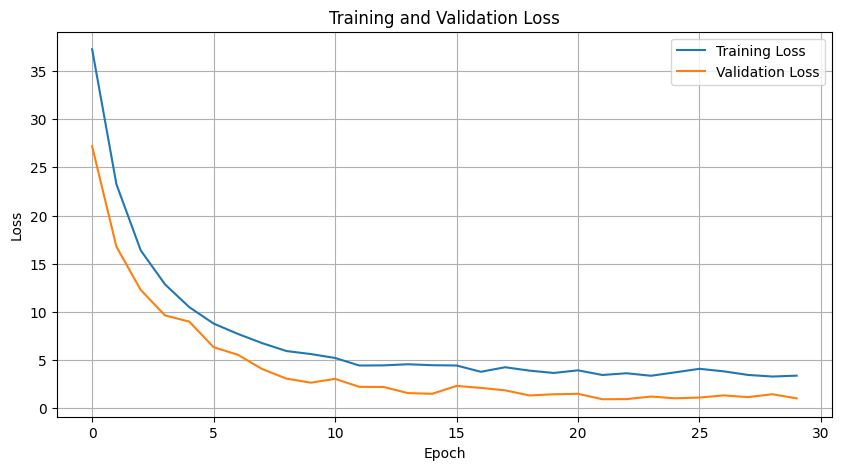


Model saved to 'v4_CNN.pth'


In [6]:
# Initialize model and training components
model = SteeringAngleCNN()
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)  # Changed to AdamW with weight decay

# Train the model
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,
    patience=8
)

# Save the trained model
torch.save(model.state_dict(), 'v4_CNN.pth')
print("\nModel saved to 'v4_CNN.pth'")


Testing the model...

Test Results (Predicting Steering Angle at t+200ms):
MSE: 1.1233 degrees²
MAE: 0.7818 degrees
Predictions within 1°: 72.6%
Predictions within 3°: 98.8%
Predictions within 5°: 99.8%


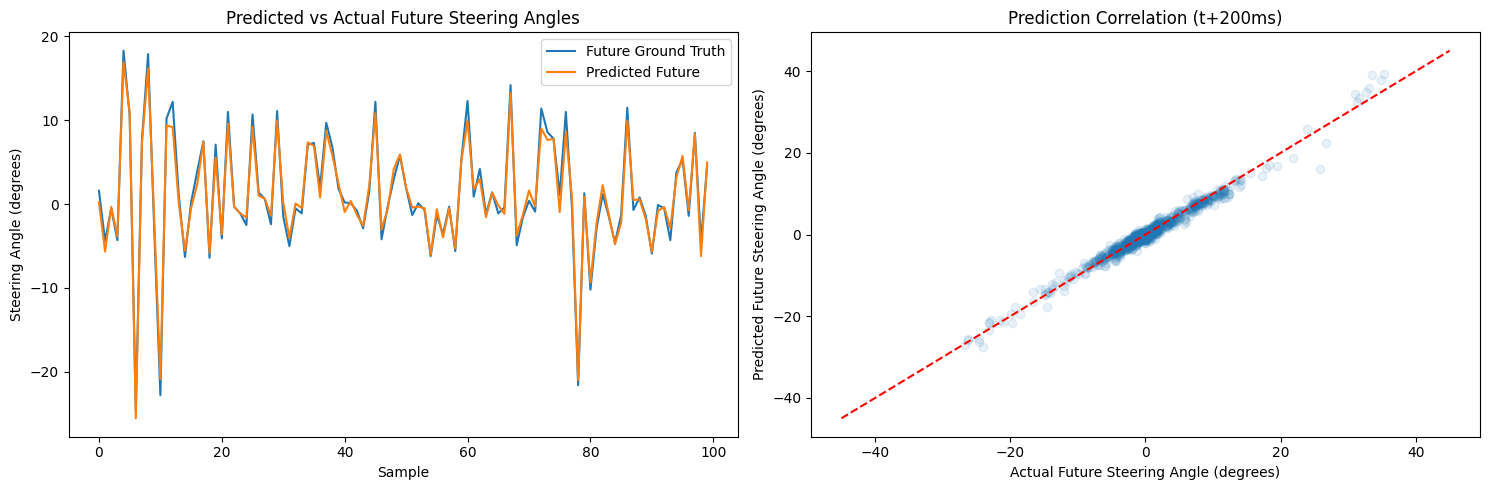


Visualizing some predictions...


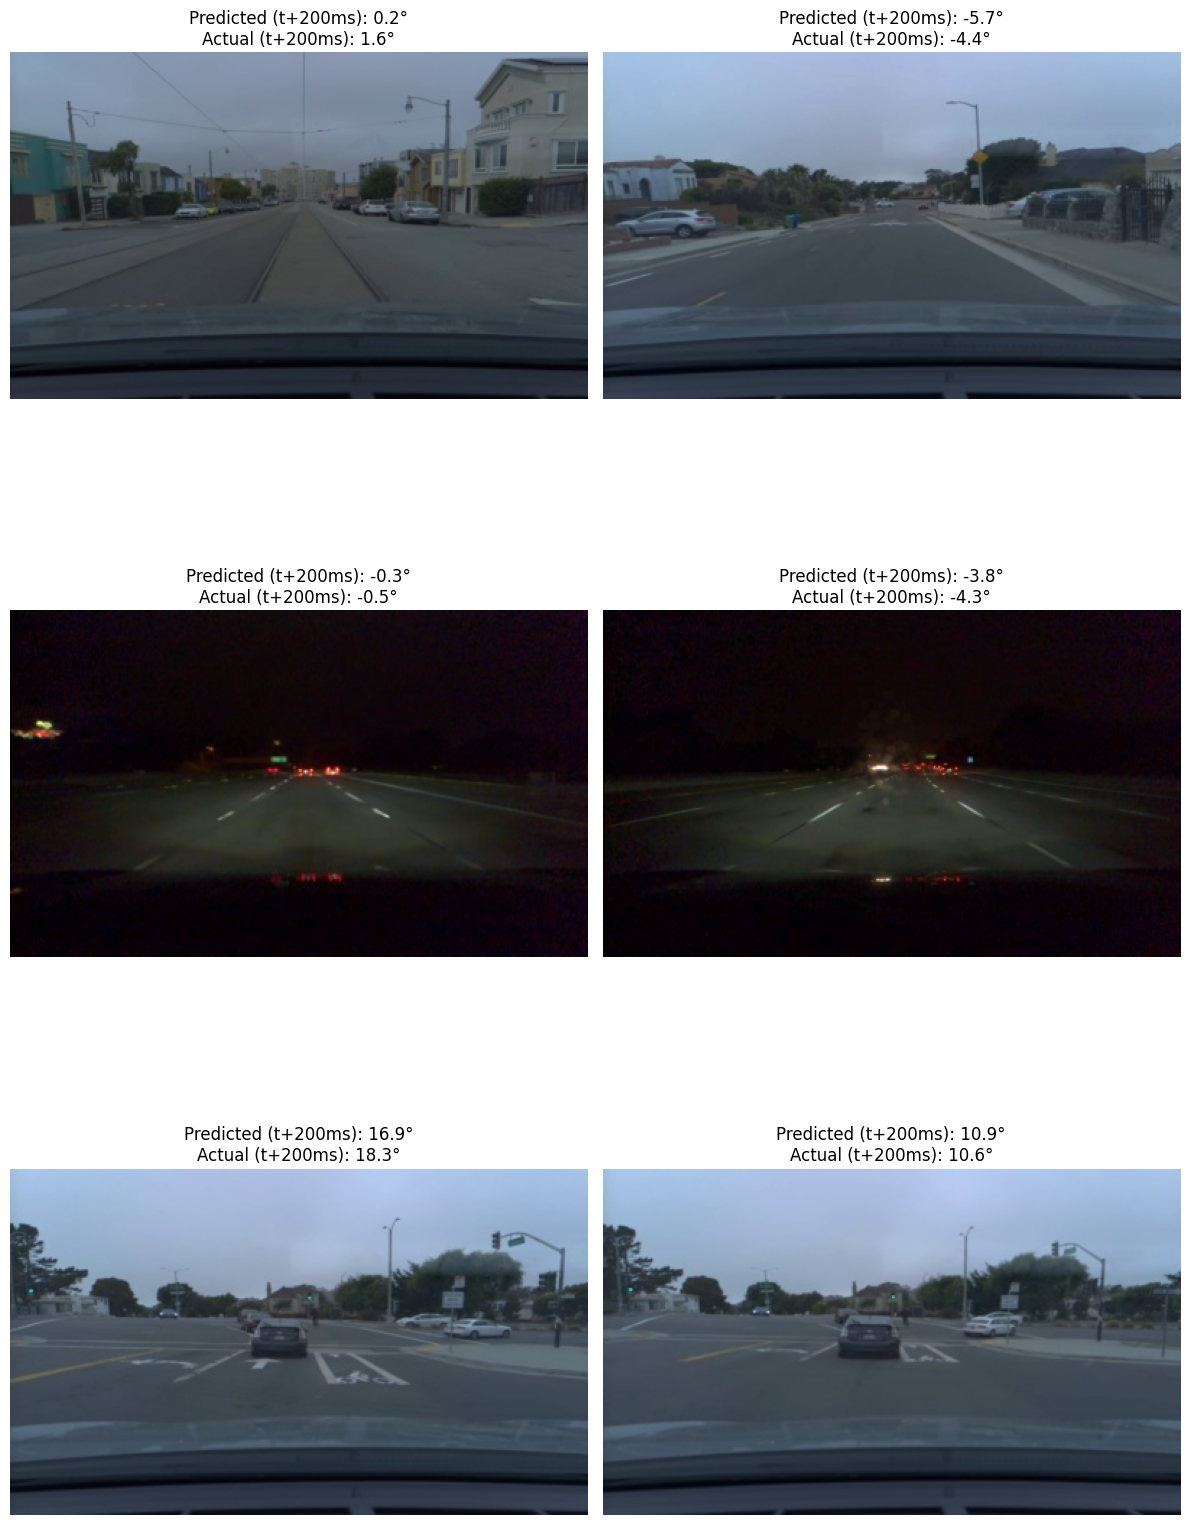

In [7]:
# Test the model
print("\nTesting the model...")
test_model(model, test_loader)

def visualize_single_batch(model, test_loader):
    model.eval()
    device = next(model.parameters()).device

    # Get a single batch
    images, sensor_data, targets = next(iter(test_loader))
    images = images.to(device)
    sensor_data = sensor_data.to(device)

    with torch.no_grad():
        predictions = model(images, sensor_data)

    # Convert to numpy for visualization
    predictions = predictions.cpu().numpy()
    targets = targets.numpy()

    # Plot a few examples
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    for i in range(min(6, len(predictions))):
        ax = axes[i//2, i%2]

        # Get the original image
        img = images[i].cpu().numpy().transpose(1, 2, 0)  # Changed inputs to images

        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(f'Predicted (t+200ms): {predictions[i][0]:.1f}°\nActual (t+200ms): {targets[i]:.1f}°')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing some predictions...")
visualize_single_batch(model, test_loader)


=== Processing 1Hz data ===

Frame reduction summary for 1Hz:
Total frames before limiting: 11372
Total frames after limiting: 11241
Reduction: 1.2%

Training and evaluating model for 1Hz data...
Calculated convolutional output size: torch.Size([1, 64, 3, 8])
Flattened conv features size: 1536
Combined input size: 1600

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 123/123 [00:31<00:00,  3.91it/s, loss=27]     


Epoch 1: Train Loss: 255.6291, Val Loss: 27.0416


Epoch 2/50: 100%|██████████| 123/123 [00:08<00:00, 14.48it/s, loss=9.32]   


Epoch 2: Train Loss: 216.7787, Val Loss: 45.4016


Epoch 3/50: 100%|██████████| 123/123 [00:08<00:00, 13.86it/s, loss=8.1]   


Epoch 3: Train Loss: 196.1522, Val Loss: 42.6025


Epoch 4/50: 100%|██████████| 123/123 [00:08<00:00, 14.34it/s, loss=101]    


Epoch 4: Train Loss: 173.4883, Val Loss: 19.5669


Epoch 5/50: 100%|██████████| 123/123 [00:08<00:00, 14.47it/s, loss=15.4]   


Epoch 5: Train Loss: 158.1501, Val Loss: 404.3092


Epoch 6/50: 100%|██████████| 123/123 [00:08<00:00, 13.83it/s, loss=13.6]   


Epoch 6: Train Loss: 152.4279, Val Loss: 14.5101


Epoch 7/50: 100%|██████████| 123/123 [00:08<00:00, 14.44it/s, loss=33.9]   


Epoch 7: Train Loss: 146.6524, Val Loss: 36.0467


Epoch 8/50: 100%|██████████| 123/123 [00:08<00:00, 14.39it/s, loss=111]    


Epoch 8: Train Loss: 133.9097, Val Loss: 173.8799


Epoch 9/50: 100%|██████████| 123/123 [00:08<00:00, 14.03it/s, loss=756]    


Epoch 9: Train Loss: 109.9917, Val Loss: 27.2174


Epoch 10/50: 100%|██████████| 123/123 [00:08<00:00, 14.41it/s, loss=22]     


Epoch 10: Train Loss: 110.5263, Val Loss: 296.0948


Epoch 11/50: 100%|██████████| 123/123 [00:08<00:00, 14.29it/s, loss=20.5]  


Epoch 11: Train Loss: 102.0024, Val Loss: 820.2282


Epoch 12/50: 100%|██████████| 123/123 [00:08<00:00, 14.00it/s, loss=22.8]   


Epoch 12: Train Loss: 92.5102, Val Loss: 244.6316


Epoch 13/50: 100%|██████████| 123/123 [00:08<00:00, 14.32it/s, loss=29.2]  


Epoch 13: Train Loss: 93.7403, Val Loss: 1942.6291


Epoch 14/50: 100%|██████████| 123/123 [00:08<00:00, 14.41it/s, loss=12.6]  


Epoch 14: Train Loss: 84.6737, Val Loss: 679873.9692
Early stopping triggered at epoch 14


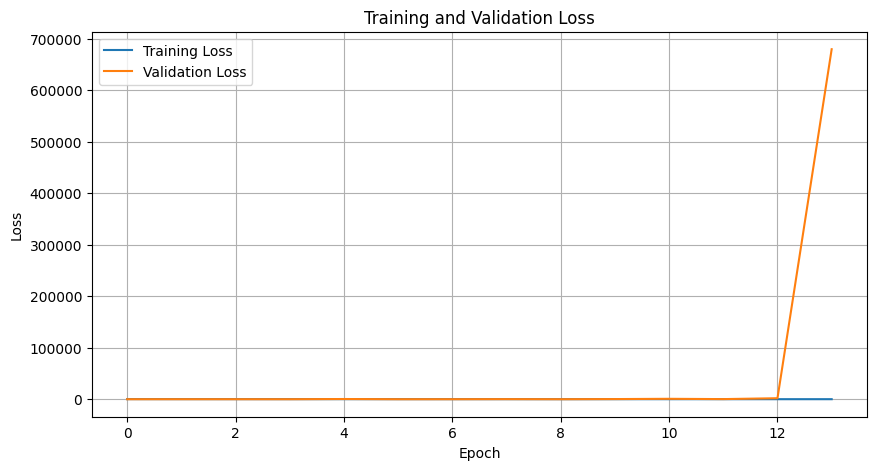

Model saved to 'v4_CNN_1hz.pth'

=== Processing 2Hz data ===

Frame reduction summary for 2Hz:
Total frames before limiting: 22566
Total frames after limiting: 11262
Reduction: 50.1%

Training and evaluating model for 2Hz data...
Calculated convolutional output size: torch.Size([1, 64, 3, 8])
Flattened conv features size: 1536
Combined input size: 1600

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 124/124 [00:30<00:00,  4.09it/s, loss=8.89]   


Epoch 1: Train Loss: 152.4824, Val Loss: 32.4017


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.81it/s, loss=8.67]  


Epoch 2: Train Loss: 118.2459, Val Loss: 17.0188


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.40it/s, loss=1.34e+3]


Epoch 3: Train Loss: 108.3662, Val Loss: 29.2256


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.80it/s, loss=9.89]  


Epoch 4: Train Loss: 94.1576, Val Loss: 19.9072


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.74it/s, loss=1.06e+3]


Epoch 5: Train Loss: 87.5675, Val Loss: 84.0383


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.47it/s, loss=5.81]  


Epoch 6: Train Loss: 82.7983, Val Loss: 137.0023


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.54it/s, loss=9.63]  


Epoch 7: Train Loss: 74.5920, Val Loss: 21.5581


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.60it/s, loss=12.6]  


Epoch 8: Train Loss: 70.8456, Val Loss: 294.1643


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.24it/s, loss=8.84]  


Epoch 9: Train Loss: 65.6545, Val Loss: 32.0321


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 14.54it/s, loss=24.5]   


Epoch 10: Train Loss: 63.2552, Val Loss: 46.4329
Early stopping triggered at epoch 10


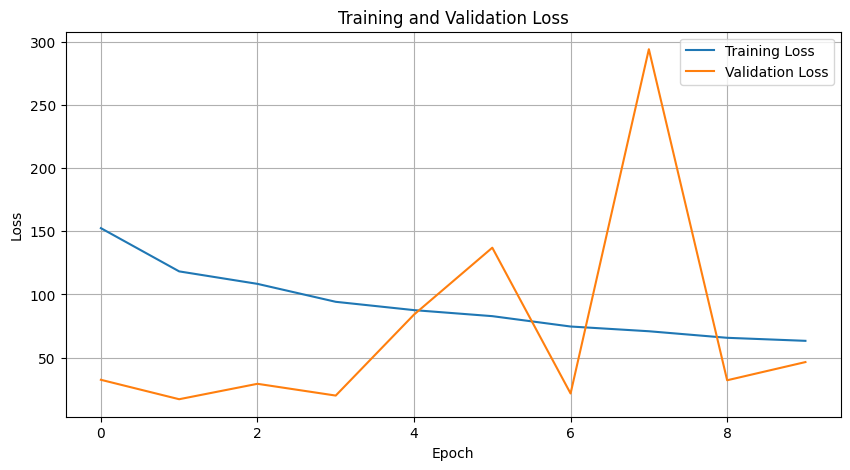

Model saved to 'v4_CNN_2hz.pth'

=== Processing 4Hz data ===

Frame reduction summary for 4Hz:
Total frames before limiting: 45010
Total frames after limiting: 11280
Reduction: 74.9%

Training and evaluating model for 4Hz data...
Calculated convolutional output size: torch.Size([1, 64, 3, 8])
Flattened conv features size: 1536
Combined input size: 1600

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 124/124 [00:30<00:00,  4.08it/s, loss=3.67]


Epoch 1: Train Loss: 45.0196, Val Loss: 5.1809


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.29it/s, loss=4.97]


Epoch 2: Train Loss: 30.9615, Val Loss: 15.5135


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.79it/s, loss=4.16]


Epoch 3: Train Loss: 28.5271, Val Loss: 10.3502


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.69it/s, loss=3.17]


Epoch 4: Train Loss: 25.0184, Val Loss: 25.0843


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.13it/s, loss=13.2]


Epoch 5: Train Loss: 23.2723, Val Loss: 69.4160


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.60it/s, loss=10.3]


Epoch 6: Train Loss: 19.4719, Val Loss: 55.4790


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.57it/s, loss=7.52]


Epoch 7: Train Loss: 18.1629, Val Loss: 429.0813


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.06it/s, loss=2.72]


Epoch 8: Train Loss: 17.5455, Val Loss: 216.4064


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.45it/s, loss=8.58]


Epoch 9: Train Loss: 17.7527, Val Loss: 86.1989
Early stopping triggered at epoch 9


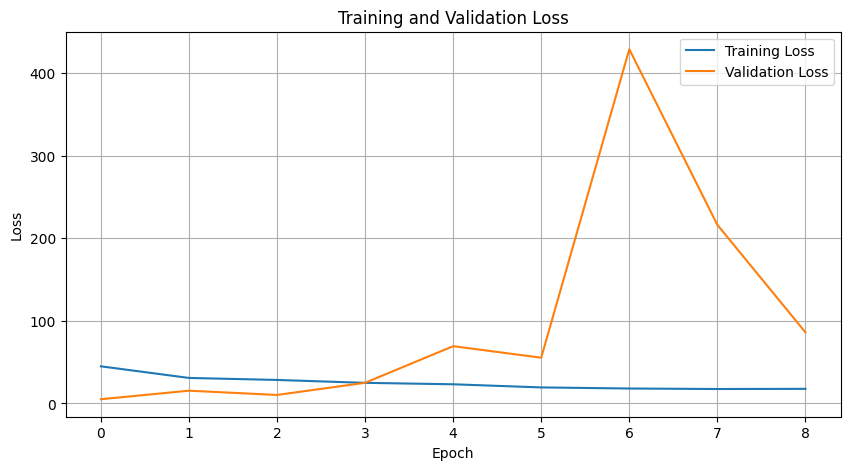

Model saved to 'v4_CNN_4hz.pth'

=== Processing 6Hz data ===

Frame reduction summary for 6Hz:
Total frames before limiting: 67425
Total frames after limiting: 11280
Reduction: 83.3%

Training and evaluating model for 6Hz data...
Calculated convolutional output size: torch.Size([1, 64, 3, 8])
Flattened conv features size: 1536
Combined input size: 1600

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 124/124 [00:30<00:00,  4.13it/s, loss=7.1] 


Epoch 1: Train Loss: 53.5656, Val Loss: 3.6600


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.63it/s, loss=11.5]


Epoch 2: Train Loss: 41.6085, Val Loss: 4.4206


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.71it/s, loss=12.1]


Epoch 3: Train Loss: 37.4074, Val Loss: 5.3227


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.37it/s, loss=8.06]


Epoch 4: Train Loss: 34.5539, Val Loss: 33.9183


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.81it/s, loss=9.64]


Epoch 5: Train Loss: 29.1162, Val Loss: 27.7222


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.69it/s, loss=10]  


Epoch 6: Train Loss: 29.2328, Val Loss: 30.1296


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.47it/s, loss=13.6]


Epoch 7: Train Loss: 24.6881, Val Loss: 24.6216


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.80it/s, loss=624] 


Epoch 8: Train Loss: 22.7051, Val Loss: 14.6154


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.72it/s, loss=6.71]


Epoch 9: Train Loss: 18.7124, Val Loss: 47.6224
Early stopping triggered at epoch 9


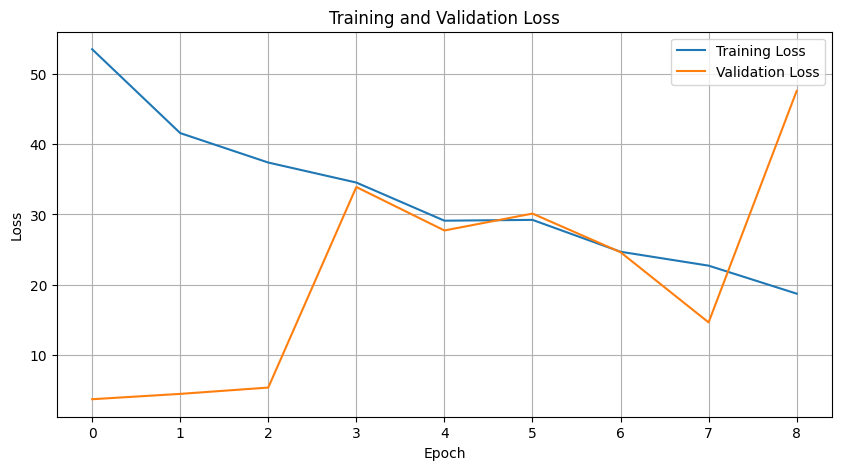

Model saved to 'v4_CNN_6hz.pth'

=== Processing 8Hz data ===

Frame reduction summary for 8Hz:
Total frames before limiting: 89835
Total frames after limiting: 11280
Reduction: 87.4%

Training and evaluating model for 8Hz data...
Calculated convolutional output size: torch.Size([1, 64, 3, 8])
Flattened conv features size: 1536
Combined input size: 1600

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 124/124 [00:31<00:00,  3.96it/s, loss=7.9] 


Epoch 1: Train Loss: 50.2215, Val Loss: 7.8663


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.63it/s, loss=12.2]


Epoch 2: Train Loss: 38.3522, Val Loss: 5.0997


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.84it/s, loss=67.3]


Epoch 3: Train Loss: 33.7609, Val Loss: 6.0571


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.29it/s, loss=5.92]


Epoch 4: Train Loss: 28.4134, Val Loss: 4.5645


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.52it/s, loss=11]  


Epoch 5: Train Loss: 23.5324, Val Loss: 4.7471


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.59it/s, loss=4.89]


Epoch 6: Train Loss: 20.5753, Val Loss: 12.2507


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.35it/s, loss=6.33]


Epoch 7: Train Loss: 17.8365, Val Loss: 14.2425


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.60it/s, loss=8.19]


Epoch 8: Train Loss: 17.2335, Val Loss: 30.1391


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.70it/s, loss=9.46]


Epoch 9: Train Loss: 14.6834, Val Loss: 43.0154


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 14.46it/s, loss=6.01]


Epoch 10: Train Loss: 16.2058, Val Loss: 43.4895


Epoch 11/50: 100%|██████████| 124/124 [00:08<00:00, 14.82it/s, loss=9.68]


Epoch 11: Train Loss: 13.1315, Val Loss: 146.2097


Epoch 12/50: 100%|██████████| 124/124 [00:08<00:00, 14.56it/s, loss=42.6]


Epoch 12: Train Loss: 14.0887, Val Loss: 47.8397
Early stopping triggered at epoch 12


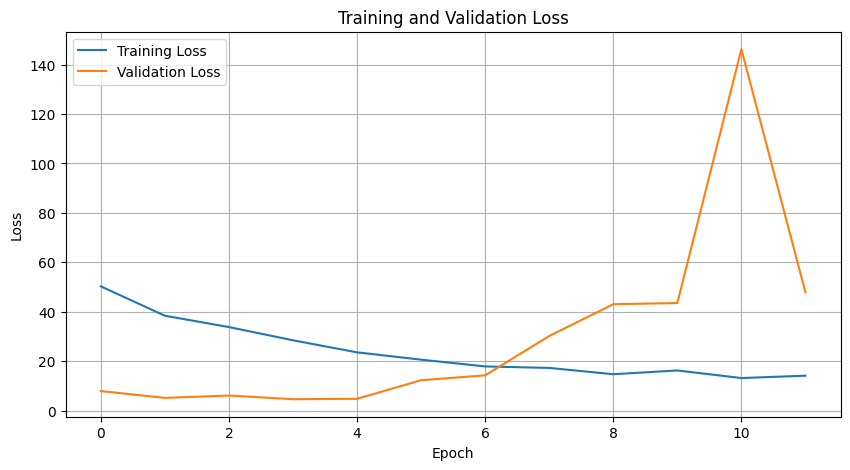

Model saved to 'v4_CNN_8hz.pth'

=== Processing 10Hz data ===

Frame reduction summary for 10Hz:
Total frames before limiting: 112239
Total frames after limiting: 11280
Reduction: 90.0%

Training and evaluating model for 10Hz data...
Calculated convolutional output size: torch.Size([1, 64, 3, 8])
Flattened conv features size: 1536
Combined input size: 1600

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 124/124 [00:29<00:00,  4.15it/s, loss=7.06]


Epoch 1: Train Loss: 27.1540, Val Loss: 2.8102


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.76it/s, loss=4.41]


Epoch 2: Train Loss: 17.6693, Val Loss: 4.0662


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.24it/s, loss=2.67]


Epoch 3: Train Loss: 15.6213, Val Loss: 2.4993


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.63it/s, loss=2.41]


Epoch 4: Train Loss: 14.9815, Val Loss: 3.2767


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.70it/s, loss=2.57]


Epoch 5: Train Loss: 12.5333, Val Loss: 3.9725


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.18it/s, loss=9.87]


Epoch 6: Train Loss: 11.4936, Val Loss: 5.7238


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.68it/s, loss=19.7]


Epoch 7: Train Loss: 11.1383, Val Loss: 25.4731


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.77it/s, loss=13.4]


Epoch 8: Train Loss: 11.5384, Val Loss: 6.2054


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.19it/s, loss=4.4] 


Epoch 9: Train Loss: 11.3251, Val Loss: 4.2038


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 14.62it/s, loss=6.23]


Epoch 10: Train Loss: 10.9614, Val Loss: 3.9558


Epoch 11/50: 100%|██████████| 124/124 [00:08<00:00, 14.58it/s, loss=5.54]


Epoch 11: Train Loss: 9.5519, Val Loss: 2.7871
Early stopping triggered at epoch 11


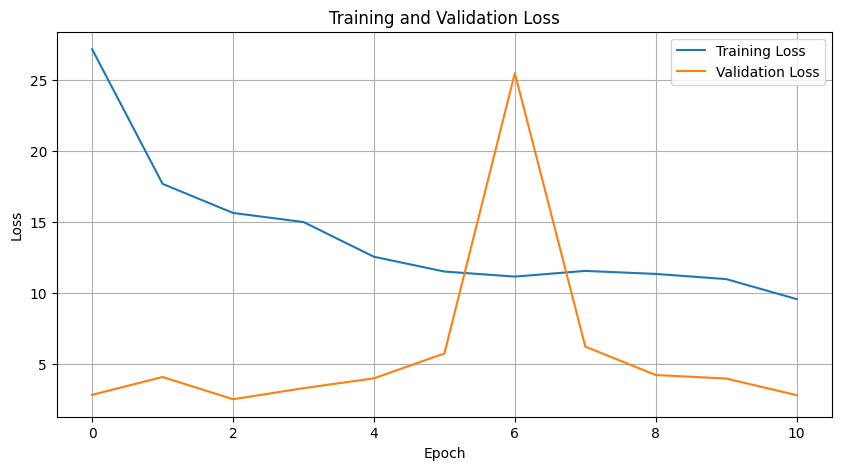

Model saved to 'v4_CNN_10hz.pth'

=== Processing 12Hz data ===

Frame reduction summary for 12Hz:
Total frames before limiting: 134656
Total frames after limiting: 11280
Reduction: 91.6%

Training and evaluating model for 12Hz data...
Calculated convolutional output size: torch.Size([1, 64, 3, 8])
Flattened conv features size: 1536
Combined input size: 1600

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 124/124 [00:08<00:00, 14.69it/s, loss=8.84]


Epoch 1: Train Loss: 16.3531, Val Loss: 2.1771


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.50it/s, loss=4.79]


Epoch 2: Train Loss: 8.7393, Val Loss: 1.8876


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.25it/s, loss=67.1]


Epoch 3: Train Loss: 6.9469, Val Loss: 1.8363


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.76it/s, loss=8.06]


Epoch 4: Train Loss: 6.4351, Val Loss: 1.7007


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.63it/s, loss=1.79]


Epoch 5: Train Loss: 6.1387, Val Loss: 2.8976


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.11it/s, loss=4.91]


Epoch 6: Train Loss: 5.5358, Val Loss: 2.1967


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.51it/s, loss=5.96]


Epoch 7: Train Loss: 4.9410, Val Loss: 2.0762


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.51it/s, loss=4.13]


Epoch 8: Train Loss: 4.6773, Val Loss: 1.9157


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.10it/s, loss=5.67]


Epoch 9: Train Loss: 5.0540, Val Loss: 5.9217


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 14.47it/s, loss=35.8]


Epoch 10: Train Loss: 4.7309, Val Loss: 2.9526


Epoch 11/50: 100%|██████████| 124/124 [00:08<00:00, 14.61it/s, loss=8.12]


Epoch 11: Train Loss: 4.3781, Val Loss: 3.6325


Epoch 12/50: 100%|██████████| 124/124 [00:08<00:00, 14.22it/s, loss=3.09]


Epoch 12: Train Loss: 4.2060, Val Loss: 1.6890


Epoch 13/50: 100%|██████████| 124/124 [00:08<00:00, 14.70it/s, loss=63]  


Epoch 13: Train Loss: 4.0630, Val Loss: 1.9798


Epoch 14/50: 100%|██████████| 124/124 [00:08<00:00, 14.71it/s, loss=2.27]


Epoch 14: Train Loss: 4.0443, Val Loss: 1.2710


Epoch 15/50: 100%|██████████| 124/124 [00:08<00:00, 14.27it/s, loss=2.44]


Epoch 15: Train Loss: 3.7529, Val Loss: 1.7671


Epoch 16/50: 100%|██████████| 124/124 [00:08<00:00, 14.76it/s, loss=35.7]


Epoch 16: Train Loss: 4.0093, Val Loss: 2.3450


Epoch 17/50: 100%|██████████| 124/124 [00:08<00:00, 14.79it/s, loss=4.66]


Epoch 17: Train Loss: 4.1619, Val Loss: 1.6208


Epoch 18/50: 100%|██████████| 124/124 [00:08<00:00, 14.22it/s, loss=12.7]


Epoch 18: Train Loss: 3.7846, Val Loss: 1.7965


Epoch 19/50: 100%|██████████| 124/124 [00:08<00:00, 14.68it/s, loss=3.78]


Epoch 19: Train Loss: 4.0322, Val Loss: 2.3545


Epoch 20/50: 100%|██████████| 124/124 [00:08<00:00, 14.70it/s, loss=2.03]


Epoch 20: Train Loss: 3.6097, Val Loss: 2.6972


Epoch 21/50: 100%|██████████| 124/124 [00:08<00:00, 14.03it/s, loss=3.9] 


Epoch 21: Train Loss: 3.5483, Val Loss: 3.5440


Epoch 22/50: 100%|██████████| 124/124 [00:08<00:00, 14.28it/s, loss=1.46]


Epoch 22: Train Loss: 4.0650, Val Loss: 3.4544
Early stopping triggered at epoch 22


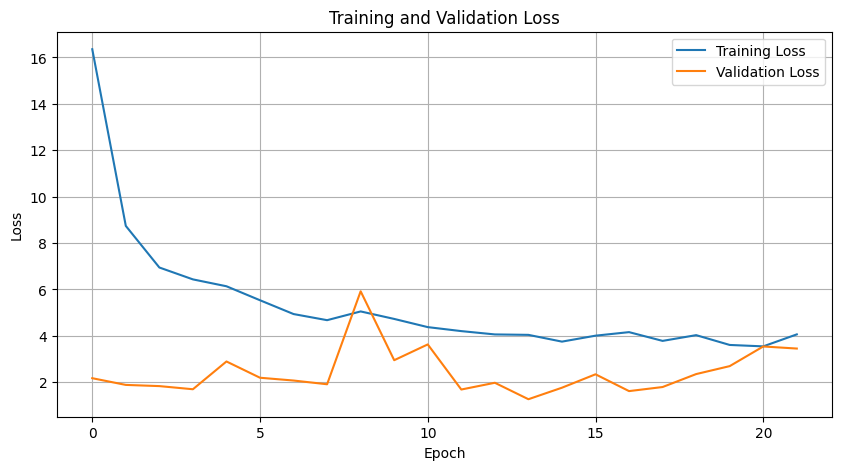

Model saved to 'v4_CNN_12hz.pth'

=== Processing 14Hz data ===

Frame reduction summary for 14Hz:
Total frames before limiting: 157028
Total frames after limiting: 11280
Reduction: 92.8%

Training and evaluating model for 14Hz data...
Calculated convolutional output size: torch.Size([1, 64, 3, 8])
Flattened conv features size: 1536
Combined input size: 1600

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 124/124 [00:08<00:00, 14.10it/s, loss=7.32]


Epoch 1: Train Loss: 14.0438, Val Loss: 2.1805


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.04it/s, loss=6.52]


Epoch 2: Train Loss: 6.6258, Val Loss: 1.7883


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.28it/s, loss=86.1]


Epoch 3: Train Loss: 6.1168, Val Loss: 2.3224


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 13.92it/s, loss=4.9] 


Epoch 4: Train Loss: 6.4132, Val Loss: 5.5700


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.26it/s, loss=1.54] 


Epoch 5: Train Loss: 5.0210, Val Loss: 2.6205


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.24it/s, loss=6.97]


Epoch 6: Train Loss: 4.3555, Val Loss: 2.8649


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 13.95it/s, loss=3.13]


Epoch 7: Train Loss: 4.3237, Val Loss: 3.0149


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.34it/s, loss=3.92]


Epoch 8: Train Loss: 4.3710, Val Loss: 2.3895


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.36it/s, loss=5.89]


Epoch 9: Train Loss: 3.6481, Val Loss: 1.7586


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 13.82it/s, loss=2.51]


Epoch 10: Train Loss: 3.6367, Val Loss: 2.2719


Epoch 11/50: 100%|██████████| 124/124 [00:08<00:00, 14.36it/s, loss=5.6] 


Epoch 11: Train Loss: 3.6689, Val Loss: 1.8138


Epoch 12/50: 100%|██████████| 124/124 [00:08<00:00, 14.21it/s, loss=5.53]


Epoch 12: Train Loss: 4.1366, Val Loss: 3.8541


Epoch 13/50: 100%|██████████| 124/124 [00:09<00:00, 13.60it/s, loss=4.48]


Epoch 13: Train Loss: 3.8606, Val Loss: 2.0441


Epoch 14/50: 100%|██████████| 124/124 [00:08<00:00, 14.47it/s, loss=3.88]


Epoch 14: Train Loss: 3.3329, Val Loss: 1.8040


Epoch 15/50: 100%|██████████| 124/124 [00:08<00:00, 14.30it/s, loss=8.43]


Epoch 15: Train Loss: 3.6293, Val Loss: 1.6940


Epoch 16/50: 100%|██████████| 124/124 [00:08<00:00, 13.97it/s, loss=3.55]


Epoch 16: Train Loss: 4.0938, Val Loss: 3.1672


Epoch 17/50: 100%|██████████| 124/124 [00:08<00:00, 14.42it/s, loss=2.78]


Epoch 17: Train Loss: 3.3892, Val Loss: 2.0594


Epoch 18/50: 100%|██████████| 124/124 [00:08<00:00, 14.64it/s, loss=2.83]


Epoch 18: Train Loss: 4.1356, Val Loss: 3.8590


Epoch 19/50: 100%|██████████| 124/124 [00:08<00:00, 14.19it/s, loss=3.07] 


Epoch 19: Train Loss: 3.5416, Val Loss: 2.3541


Epoch 20/50: 100%|██████████| 124/124 [00:08<00:00, 14.75it/s, loss=2.96]


Epoch 20: Train Loss: 3.3934, Val Loss: 2.4994


Epoch 21/50: 100%|██████████| 124/124 [00:08<00:00, 14.72it/s, loss=2.06]


Epoch 21: Train Loss: 3.1273, Val Loss: 2.5737


Epoch 22/50: 100%|██████████| 124/124 [00:08<00:00, 14.26it/s, loss=5.14]


Epoch 22: Train Loss: 3.2750, Val Loss: 3.1383


Epoch 23/50: 100%|██████████| 124/124 [00:08<00:00, 14.80it/s, loss=8.42]


Epoch 23: Train Loss: 3.1459, Val Loss: 3.9812
Early stopping triggered at epoch 23


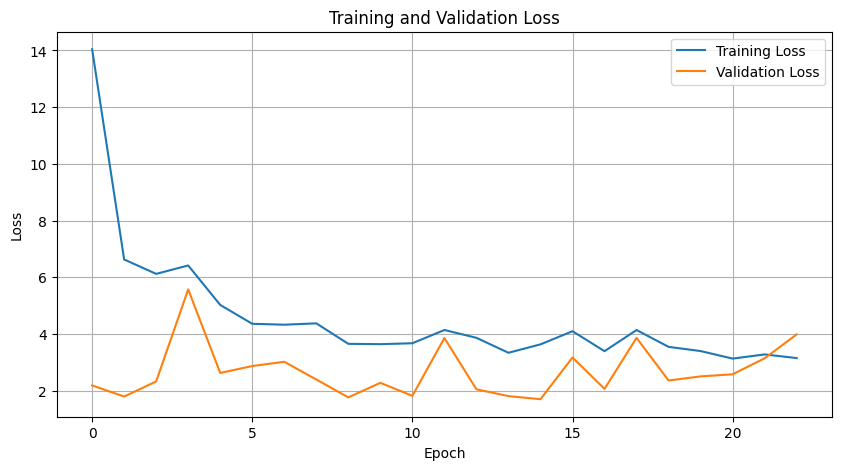

Model saved to 'v4_CNN_14hz.pth'

=== Processing 16Hz data ===

Frame reduction summary for 16Hz:
Total frames before limiting: 179463
Total frames after limiting: 11280
Reduction: 93.7%

Training and evaluating model for 16Hz data...
Calculated convolutional output size: torch.Size([1, 64, 3, 8])
Flattened conv features size: 1536
Combined input size: 1600

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 124/124 [00:08<00:00, 14.51it/s, loss=7.41]


Epoch 1: Train Loss: 11.8278, Val Loss: 1.8626


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.36it/s, loss=3.8] 


Epoch 2: Train Loss: 6.3060, Val Loss: 4.0741


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.62it/s, loss=3.71]


Epoch 3: Train Loss: 5.5037, Val Loss: 1.6328


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.49it/s, loss=1.38]


Epoch 4: Train Loss: 4.4070, Val Loss: 2.0054


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.57it/s, loss=4.32]


Epoch 5: Train Loss: 4.6898, Val Loss: 2.6824


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.71it/s, loss=5.5] 


Epoch 6: Train Loss: 4.0792, Val Loss: 1.5232


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.41it/s, loss=11]  


Epoch 7: Train Loss: 4.1385, Val Loss: 2.1501


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.28it/s, loss=7.55]


Epoch 8: Train Loss: 4.3069, Val Loss: 1.3559


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.46it/s, loss=4.69]


Epoch 9: Train Loss: 3.7837, Val Loss: 1.2161


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 14.22it/s, loss=21.7]


Epoch 10: Train Loss: 3.5380, Val Loss: 1.4449


Epoch 11/50: 100%|██████████| 124/124 [00:08<00:00, 14.59it/s, loss=4.29]


Epoch 11: Train Loss: 3.6051, Val Loss: 3.0978


Epoch 12/50: 100%|██████████| 124/124 [00:08<00:00, 14.62it/s, loss=2.63]


Epoch 12: Train Loss: 3.3388, Val Loss: 2.4935


Epoch 13/50: 100%|██████████| 124/124 [00:08<00:00, 14.34it/s, loss=7.96]


Epoch 13: Train Loss: 3.7349, Val Loss: 1.9427


Epoch 14/50: 100%|██████████| 124/124 [00:08<00:00, 14.51it/s, loss=9.13]


Epoch 14: Train Loss: 3.3792, Val Loss: 2.4087


Epoch 15/50: 100%|██████████| 124/124 [00:08<00:00, 14.72it/s, loss=2.22]


Epoch 15: Train Loss: 3.7689, Val Loss: 2.3589


Epoch 16/50: 100%|██████████| 124/124 [00:08<00:00, 14.23it/s, loss=10.9] 


Epoch 16: Train Loss: 3.3917, Val Loss: 2.6101


Epoch 17/50: 100%|██████████| 124/124 [00:08<00:00, 14.69it/s, loss=4.94]


Epoch 17: Train Loss: 3.0230, Val Loss: 1.0346


Epoch 18/50: 100%|██████████| 124/124 [00:08<00:00, 14.63it/s, loss=13.7]


Epoch 18: Train Loss: 3.4937, Val Loss: 1.1652


Epoch 19/50: 100%|██████████| 124/124 [00:08<00:00, 14.14it/s, loss=2.46]


Epoch 19: Train Loss: 3.4429, Val Loss: 1.5418


Epoch 20/50: 100%|██████████| 124/124 [00:08<00:00, 14.68it/s, loss=11.6]


Epoch 20: Train Loss: 3.5038, Val Loss: 1.8584


Epoch 21/50: 100%|██████████| 124/124 [00:08<00:00, 14.71it/s, loss=2.6] 


Epoch 21: Train Loss: 3.3814, Val Loss: 1.9961


Epoch 22/50: 100%|██████████| 124/124 [00:08<00:00, 14.31it/s, loss=1.25]


Epoch 22: Train Loss: 3.0934, Val Loss: 1.6093


Epoch 23/50: 100%|██████████| 124/124 [00:08<00:00, 14.47it/s, loss=1.3] 


Epoch 23: Train Loss: 2.9804, Val Loss: 2.1281


Epoch 24/50: 100%|██████████| 124/124 [00:08<00:00, 14.46it/s, loss=6.41]


Epoch 24: Train Loss: 2.9890, Val Loss: 2.6357


Epoch 25/50: 100%|██████████| 124/124 [00:08<00:00, 14.10it/s, loss=9.63]


Epoch 25: Train Loss: 2.9737, Val Loss: 1.8198
Early stopping triggered at epoch 25


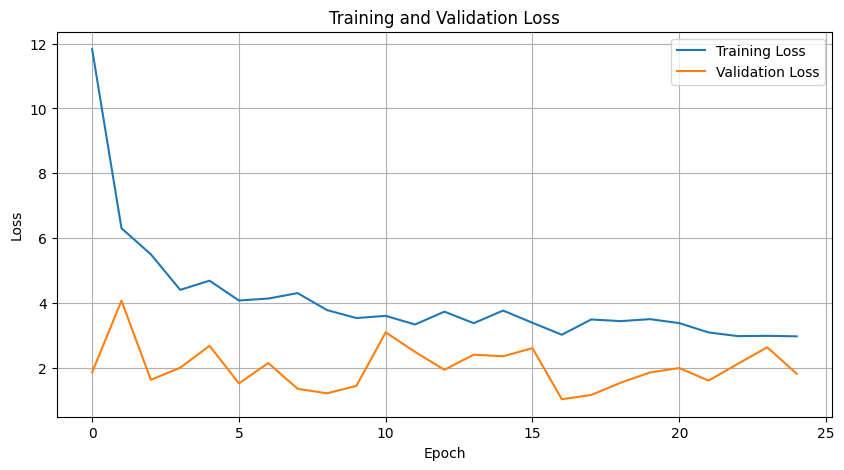

Model saved to 'v4_CNN_16hz.pth'

=== Processing 18Hz data ===

Frame reduction summary for 18Hz:
Total frames before limiting: 201825
Total frames after limiting: 11280
Reduction: 94.4%

Training and evaluating model for 18Hz data...
Calculated convolutional output size: torch.Size([1, 64, 3, 8])
Flattened conv features size: 1536
Combined input size: 1600

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 124/124 [00:08<00:00, 14.40it/s, loss=5.5] 


Epoch 1: Train Loss: 10.9524, Val Loss: 2.5246


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.38it/s, loss=5.22]


Epoch 2: Train Loss: 5.1535, Val Loss: 2.7372


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.02it/s, loss=3.53]


Epoch 3: Train Loss: 4.9317, Val Loss: 2.0026


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.73it/s, loss=3.16]


Epoch 4: Train Loss: 4.1674, Val Loss: 8.6747


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.60it/s, loss=17.3]


Epoch 5: Train Loss: 3.9732, Val Loss: 2.9141


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 13.98it/s, loss=3.96]


Epoch 6: Train Loss: 4.0593, Val Loss: 2.2584


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.57it/s, loss=3.02]


Epoch 7: Train Loss: 3.5799, Val Loss: 20.0003


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.66it/s, loss=23.3]


Epoch 8: Train Loss: 3.0877, Val Loss: 19.3426


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.26it/s, loss=1.92]


Epoch 9: Train Loss: 3.4015, Val Loss: 12.7313


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 14.55it/s, loss=1.98]


Epoch 10: Train Loss: 3.1575, Val Loss: 4.1761


Epoch 11/50: 100%|██████████| 124/124 [00:08<00:00, 14.51it/s, loss=10.4]


Epoch 11: Train Loss: 2.8688, Val Loss: 1.8822


Epoch 12/50: 100%|██████████| 124/124 [00:08<00:00, 13.86it/s, loss=2.62]


Epoch 12: Train Loss: 2.9993, Val Loss: 1.9640


Epoch 13/50: 100%|██████████| 124/124 [00:08<00:00, 13.81it/s, loss=1.8] 


Epoch 13: Train Loss: 2.8263, Val Loss: 1.7456


Epoch 14/50: 100%|██████████| 124/124 [00:08<00:00, 14.28it/s, loss=1.17]


Epoch 14: Train Loss: 2.7772, Val Loss: 1.8845


Epoch 15/50: 100%|██████████| 124/124 [00:08<00:00, 14.39it/s, loss=23.4] 


Epoch 15: Train Loss: 2.7516, Val Loss: 1.6864


Epoch 16/50: 100%|██████████| 124/124 [00:08<00:00, 14.70it/s, loss=4.13]


Epoch 16: Train Loss: 2.5575, Val Loss: 2.5044


Epoch 17/50: 100%|██████████| 124/124 [00:08<00:00, 14.40it/s, loss=6.63]


Epoch 17: Train Loss: 2.5393, Val Loss: 1.4117


Epoch 18/50: 100%|██████████| 124/124 [00:08<00:00, 14.30it/s, loss=4.42] 


Epoch 18: Train Loss: 2.4654, Val Loss: 1.5163


Epoch 19/50: 100%|██████████| 124/124 [00:08<00:00, 14.58it/s, loss=1.8] 


Epoch 19: Train Loss: 3.0251, Val Loss: 1.4894


Epoch 20/50: 100%|██████████| 124/124 [00:08<00:00, 14.38it/s, loss=2.46]


Epoch 20: Train Loss: 2.7532, Val Loss: 4.7249


Epoch 21/50: 100%|██████████| 124/124 [00:08<00:00, 14.51it/s, loss=3.27]


Epoch 21: Train Loss: 2.7022, Val Loss: 3.6101


Epoch 22/50: 100%|██████████| 124/124 [00:08<00:00, 14.67it/s, loss=10.3] 


Epoch 22: Train Loss: 2.7193, Val Loss: 1.9737


Epoch 23/50: 100%|██████████| 124/124 [00:08<00:00, 14.36it/s, loss=6.82] 


Epoch 23: Train Loss: 2.4467, Val Loss: 2.4964


Epoch 24/50: 100%|██████████| 124/124 [00:08<00:00, 14.55it/s, loss=19.3] 


Epoch 24: Train Loss: 2.5011, Val Loss: 1.3483


Epoch 25/50: 100%|██████████| 124/124 [00:08<00:00, 14.47it/s, loss=2.53] 


Epoch 25: Train Loss: 2.5234, Val Loss: 1.7767


Epoch 26/50: 100%|██████████| 124/124 [00:08<00:00, 14.43it/s, loss=1.35]


Epoch 26: Train Loss: 2.5950, Val Loss: 5.1566


Epoch 27/50: 100%|██████████| 124/124 [00:08<00:00, 14.61it/s, loss=1.8]  


Epoch 27: Train Loss: 2.4340, Val Loss: 3.4104


Epoch 28/50: 100%|██████████| 124/124 [00:08<00:00, 14.53it/s, loss=1.66]


Epoch 28: Train Loss: 2.5056, Val Loss: 1.8556


Epoch 29/50: 100%|██████████| 124/124 [00:08<00:00, 14.23it/s, loss=2.07]


Epoch 29: Train Loss: 2.3812, Val Loss: 5.0355


Epoch 30/50: 100%|██████████| 124/124 [00:08<00:00, 14.61it/s, loss=2.28]


Epoch 30: Train Loss: 2.3971, Val Loss: 11.0704


Epoch 31/50: 100%|██████████| 124/124 [00:08<00:00, 14.61it/s, loss=1.12] 


Epoch 31: Train Loss: 2.3417, Val Loss: 2.7400


Epoch 32/50: 100%|██████████| 124/124 [00:08<00:00, 14.28it/s, loss=3.4]  


Epoch 32: Train Loss: 2.2513, Val Loss: 2.9791
Early stopping triggered at epoch 32


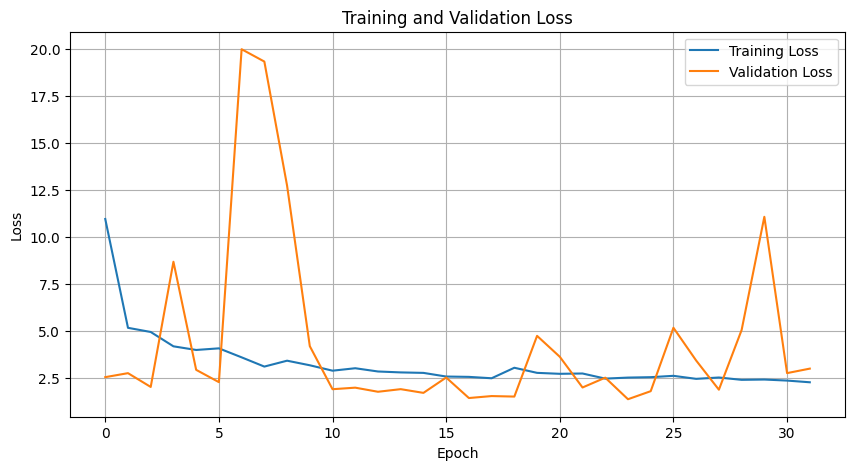

Model saved to 'v4_CNN_18hz.pth'

=== Processing 20Hz data ===

Frame reduction summary for 20Hz:
Total frames before limiting: 224190
Total frames after limiting: 11280
Reduction: 95.0%

Training and evaluating model for 20Hz data...
Calculated convolutional output size: torch.Size([1, 64, 3, 8])
Flattened conv features size: 1536
Combined input size: 1600

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 124/124 [00:08<00:00, 14.33it/s, loss=19]  


Epoch 1: Train Loss: 11.6072, Val Loss: 3.5268


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.43it/s, loss=6.76]


Epoch 2: Train Loss: 5.3070, Val Loss: 1.2210


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.29it/s, loss=3.48]


Epoch 3: Train Loss: 4.3752, Val Loss: 2.1690


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.71it/s, loss=6.21]


Epoch 4: Train Loss: 3.8713, Val Loss: 1.2598


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.54it/s, loss=4.8] 


Epoch 5: Train Loss: 3.9282, Val Loss: 2.0648


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.12it/s, loss=9.61]


Epoch 6: Train Loss: 3.6199, Val Loss: 1.5143


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.57it/s, loss=6.73]


Epoch 7: Train Loss: 3.3356, Val Loss: 2.3703


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.57it/s, loss=5.36]


Epoch 8: Train Loss: 3.2827, Val Loss: 1.7379


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.03it/s, loss=2.03]


Epoch 9: Train Loss: 3.1291, Val Loss: 1.8028


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 14.54it/s, loss=6.34]


Epoch 10: Train Loss: 2.8399, Val Loss: 1.4150
Early stopping triggered at epoch 10


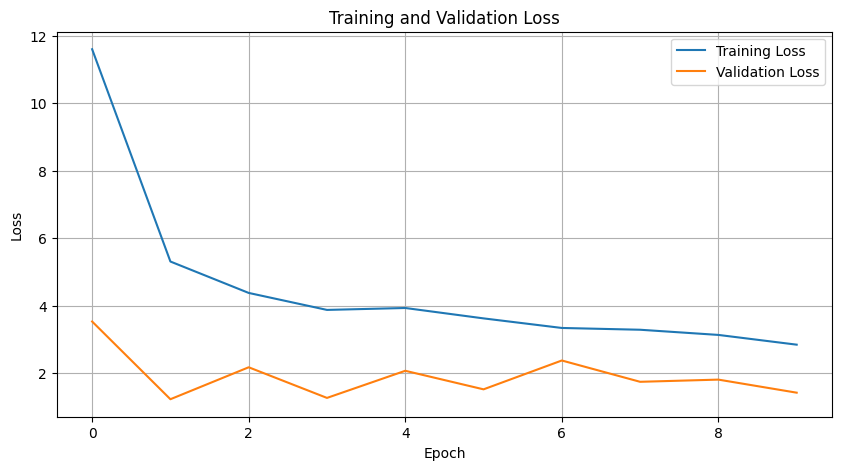

Model saved to 'v4_CNN_20hz.pth'

=== Processing 22Hz data ===

Frame reduction summary for 22Hz:
Total frames before limiting: 224234
Total frames after limiting: 11280
Reduction: 95.0%

Training and evaluating model for 22Hz data...
Calculated convolutional output size: torch.Size([1, 64, 3, 8])
Flattened conv features size: 1536
Combined input size: 1600

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 124/124 [00:08<00:00, 14.01it/s, loss=5.27]


Epoch 1: Train Loss: 10.9504, Val Loss: 1.7880


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.41it/s, loss=3.6] 


Epoch 2: Train Loss: 5.8628, Val Loss: 1.1452


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.65it/s, loss=14.3]


Epoch 3: Train Loss: 4.4871, Val Loss: 1.7501


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.25it/s, loss=4.31]


Epoch 4: Train Loss: 3.8567, Val Loss: 1.3165


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.44it/s, loss=3.16]


Epoch 5: Train Loss: 3.5383, Val Loss: 1.3584


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.54it/s, loss=2.66]


Epoch 6: Train Loss: 3.6015, Val Loss: 1.8922


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.19it/s, loss=2.68]


Epoch 7: Train Loss: 3.3519, Val Loss: 1.4943


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.52it/s, loss=38.8] 


Epoch 8: Train Loss: 3.1736, Val Loss: 1.5783


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.49it/s, loss=13.9]


Epoch 9: Train Loss: 2.9306, Val Loss: 1.1393


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 13.96it/s, loss=6.32]


Epoch 10: Train Loss: 3.1603, Val Loss: 1.4113


Epoch 11/50: 100%|██████████| 124/124 [00:08<00:00, 14.27it/s, loss=3.94]


Epoch 11: Train Loss: 2.8513, Val Loss: 2.5715


Epoch 12/50: 100%|██████████| 124/124 [00:08<00:00, 14.44it/s, loss=1.61]


Epoch 12: Train Loss: 2.7567, Val Loss: 1.6230


Epoch 13/50: 100%|██████████| 124/124 [00:08<00:00, 14.06it/s, loss=5.82] 


Epoch 13: Train Loss: 2.7860, Val Loss: 1.1867


Epoch 14/50: 100%|██████████| 124/124 [00:08<00:00, 14.37it/s, loss=3.07] 


Epoch 14: Train Loss: 2.7628, Val Loss: 1.2456


Epoch 15/50: 100%|██████████| 124/124 [00:08<00:00, 14.54it/s, loss=5.97]


Epoch 15: Train Loss: 2.6650, Val Loss: 1.7565


Epoch 16/50: 100%|██████████| 124/124 [00:08<00:00, 14.05it/s, loss=3.26]


Epoch 16: Train Loss: 2.6605, Val Loss: 1.0473


Epoch 17/50: 100%|██████████| 124/124 [00:08<00:00, 14.48it/s, loss=3.74]


Epoch 17: Train Loss: 2.7397, Val Loss: 1.4439


Epoch 18/50: 100%|██████████| 124/124 [00:08<00:00, 14.47it/s, loss=8.12]


Epoch 18: Train Loss: 2.8045, Val Loss: 1.4133


Epoch 19/50: 100%|██████████| 124/124 [00:08<00:00, 14.28it/s, loss=1.86]


Epoch 19: Train Loss: 2.6777, Val Loss: 1.8149


Epoch 20/50: 100%|██████████| 124/124 [00:08<00:00, 14.58it/s, loss=2.92] 


Epoch 20: Train Loss: 2.6344, Val Loss: 1.7838


Epoch 21/50: 100%|██████████| 124/124 [00:08<00:00, 14.51it/s, loss=2.66]


Epoch 21: Train Loss: 2.5392, Val Loss: 2.0643


Epoch 22/50: 100%|██████████| 124/124 [00:08<00:00, 14.15it/s, loss=3.09] 


Epoch 22: Train Loss: 2.4899, Val Loss: 2.4888


Epoch 23/50: 100%|██████████| 124/124 [00:08<00:00, 14.66it/s, loss=2.07] 


Epoch 23: Train Loss: 2.5978, Val Loss: 5.4288


Epoch 24/50: 100%|██████████| 124/124 [00:08<00:00, 14.56it/s, loss=17.4]


Epoch 24: Train Loss: 2.6542, Val Loss: 1.4219
Early stopping triggered at epoch 24


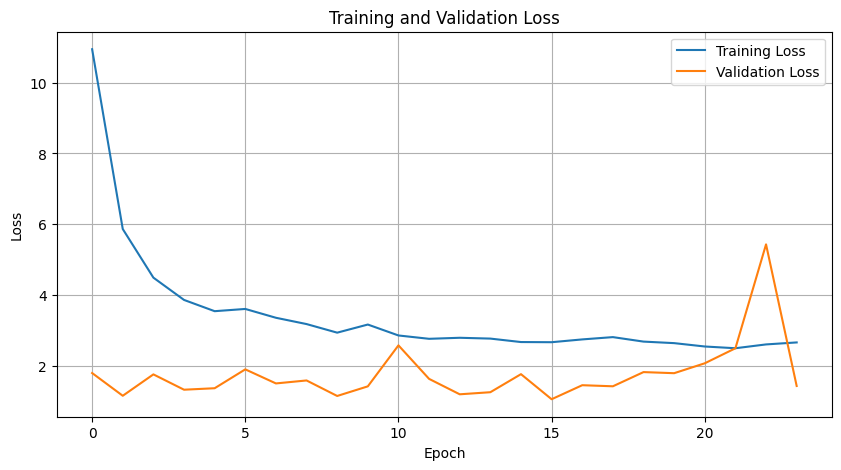

Model saved to 'v4_CNN_22hz.pth'

=== Processing 25Hz data ===

Frame reduction summary for 25Hz:
Total frames before limiting: 224234
Total frames after limiting: 11280
Reduction: 95.0%

Training and evaluating model for 25Hz data...
Calculated convolutional output size: torch.Size([1, 64, 3, 8])
Flattened conv features size: 1536
Combined input size: 1600

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 124/124 [00:08<00:00, 14.27it/s, loss=18]  


Epoch 1: Train Loss: 10.7031, Val Loss: 4.1253


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.46it/s, loss=6.13]


Epoch 2: Train Loss: 4.9642, Val Loss: 2.1806


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.40it/s, loss=5.05]


Epoch 3: Train Loss: 4.3324, Val Loss: 7.0803


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.22it/s, loss=3.27]


Epoch 4: Train Loss: 3.7261, Val Loss: 4.8212


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.44it/s, loss=4.65]


Epoch 5: Train Loss: 3.2894, Val Loss: 1.7952


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.28it/s, loss=3.78]


Epoch 6: Train Loss: 3.7360, Val Loss: 1.8523


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.28it/s, loss=2.11]


Epoch 7: Train Loss: 3.2408, Val Loss: 2.2604


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.54it/s, loss=2.46]


Epoch 8: Train Loss: 2.8366, Val Loss: 1.8560


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.32it/s, loss=16.2]


Epoch 9: Train Loss: 2.8766, Val Loss: 1.5887


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 14.55it/s, loss=2.05]


Epoch 10: Train Loss: 3.2008, Val Loss: 2.1803


Epoch 11/50: 100%|██████████| 124/124 [00:08<00:00, 14.43it/s, loss=24.8]


Epoch 11: Train Loss: 2.9538, Val Loss: 1.6105


Epoch 12/50: 100%|██████████| 124/124 [00:08<00:00, 14.21it/s, loss=1.26]


Epoch 12: Train Loss: 3.0543, Val Loss: 2.4824


Epoch 13/50: 100%|██████████| 124/124 [00:08<00:00, 14.46it/s, loss=1.99]


Epoch 13: Train Loss: 2.9887, Val Loss: 3.5928


Epoch 14/50: 100%|██████████| 124/124 [00:08<00:00, 14.47it/s, loss=6.2] 


Epoch 14: Train Loss: 2.5254, Val Loss: 2.1604


Epoch 15/50: 100%|██████████| 124/124 [00:08<00:00, 13.92it/s, loss=1.6] 


Epoch 15: Train Loss: 2.5866, Val Loss: 2.0487


Epoch 16/50: 100%|██████████| 124/124 [00:08<00:00, 14.42it/s, loss=4.83]


Epoch 16: Train Loss: 2.7479, Val Loss: 1.2366


Epoch 17/50: 100%|██████████| 124/124 [00:08<00:00, 14.23it/s, loss=6.04]


Epoch 17: Train Loss: 3.0062, Val Loss: 1.7547


Epoch 18/50: 100%|██████████| 124/124 [00:08<00:00, 14.01it/s, loss=16.6]


Epoch 18: Train Loss: 2.6201, Val Loss: 1.2274


Epoch 19/50: 100%|██████████| 124/124 [00:08<00:00, 14.63it/s, loss=1.99]


Epoch 19: Train Loss: 2.7371, Val Loss: 1.5229


Epoch 20/50: 100%|██████████| 124/124 [00:08<00:00, 14.53it/s, loss=3]   


Epoch 20: Train Loss: 2.7830, Val Loss: 1.1940


Epoch 21/50: 100%|██████████| 124/124 [00:08<00:00, 14.12it/s, loss=2.32] 


Epoch 21: Train Loss: 2.5848, Val Loss: 2.9612


Epoch 22/50: 100%|██████████| 124/124 [00:08<00:00, 14.67it/s, loss=4.25] 


Epoch 22: Train Loss: 2.6715, Val Loss: 2.2225


Epoch 23/50: 100%|██████████| 124/124 [00:08<00:00, 14.66it/s, loss=3.21]


Epoch 23: Train Loss: 2.4713, Val Loss: 2.1243


Epoch 24/50: 100%|██████████| 124/124 [00:08<00:00, 14.18it/s, loss=2.12]


Epoch 24: Train Loss: 2.5782, Val Loss: 1.4643


Epoch 25/50: 100%|██████████| 124/124 [00:08<00:00, 14.53it/s, loss=13.5] 


Epoch 25: Train Loss: 2.1877, Val Loss: 1.1417


Epoch 26/50: 100%|██████████| 124/124 [00:08<00:00, 14.67it/s, loss=5.99] 


Epoch 26: Train Loss: 2.3923, Val Loss: 2.2263


Epoch 27/50: 100%|██████████| 124/124 [00:08<00:00, 14.08it/s, loss=3.43]


Epoch 27: Train Loss: 2.4323, Val Loss: 1.9069


Epoch 28/50: 100%|██████████| 124/124 [00:08<00:00, 14.62it/s, loss=1.5] 


Epoch 28: Train Loss: 2.2825, Val Loss: 0.9903


Epoch 29/50: 100%|██████████| 124/124 [00:08<00:00, 14.60it/s, loss=2.27]


Epoch 29: Train Loss: 2.1403, Val Loss: 1.2967


Epoch 30/50: 100%|██████████| 124/124 [00:08<00:00, 14.16it/s, loss=13]  


Epoch 30: Train Loss: 2.2736, Val Loss: 1.6738


Epoch 31/50: 100%|██████████| 124/124 [00:08<00:00, 14.66it/s, loss=2.25] 


Epoch 31: Train Loss: 2.1365, Val Loss: 4.3800


Epoch 32/50: 100%|██████████| 124/124 [00:08<00:00, 14.67it/s, loss=1.57]


Epoch 32: Train Loss: 2.3398, Val Loss: 2.2363


Epoch 33/50: 100%|██████████| 124/124 [00:08<00:00, 14.22it/s, loss=1.34] 


Epoch 33: Train Loss: 2.4968, Val Loss: 7.5315


Epoch 34/50: 100%|██████████| 124/124 [00:08<00:00, 14.60it/s, loss=5.28]


Epoch 34: Train Loss: 2.2371, Val Loss: 1.2331


Epoch 35/50: 100%|██████████| 124/124 [00:08<00:00, 14.60it/s, loss=1.92]


Epoch 35: Train Loss: 2.0555, Val Loss: 1.0509


Epoch 36/50: 100%|██████████| 124/124 [00:08<00:00, 14.00it/s, loss=5.06] 


Epoch 36: Train Loss: 2.3029, Val Loss: 2.2754
Early stopping triggered at epoch 36


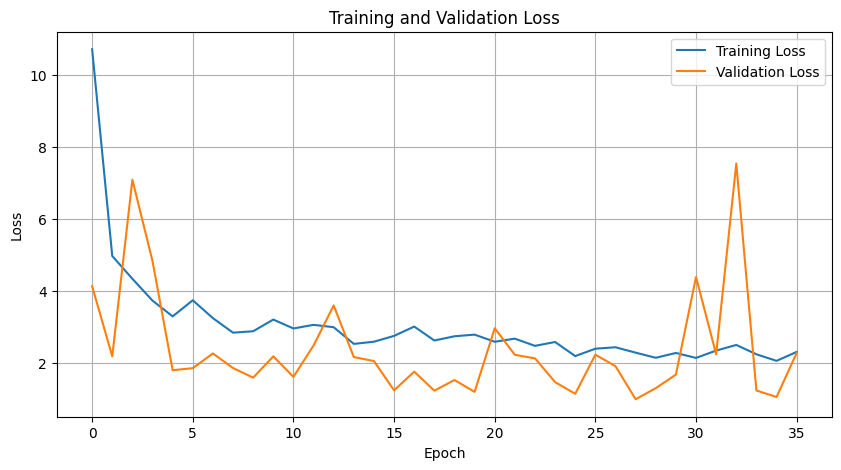

Model saved to 'v4_CNN_25hz.pth'


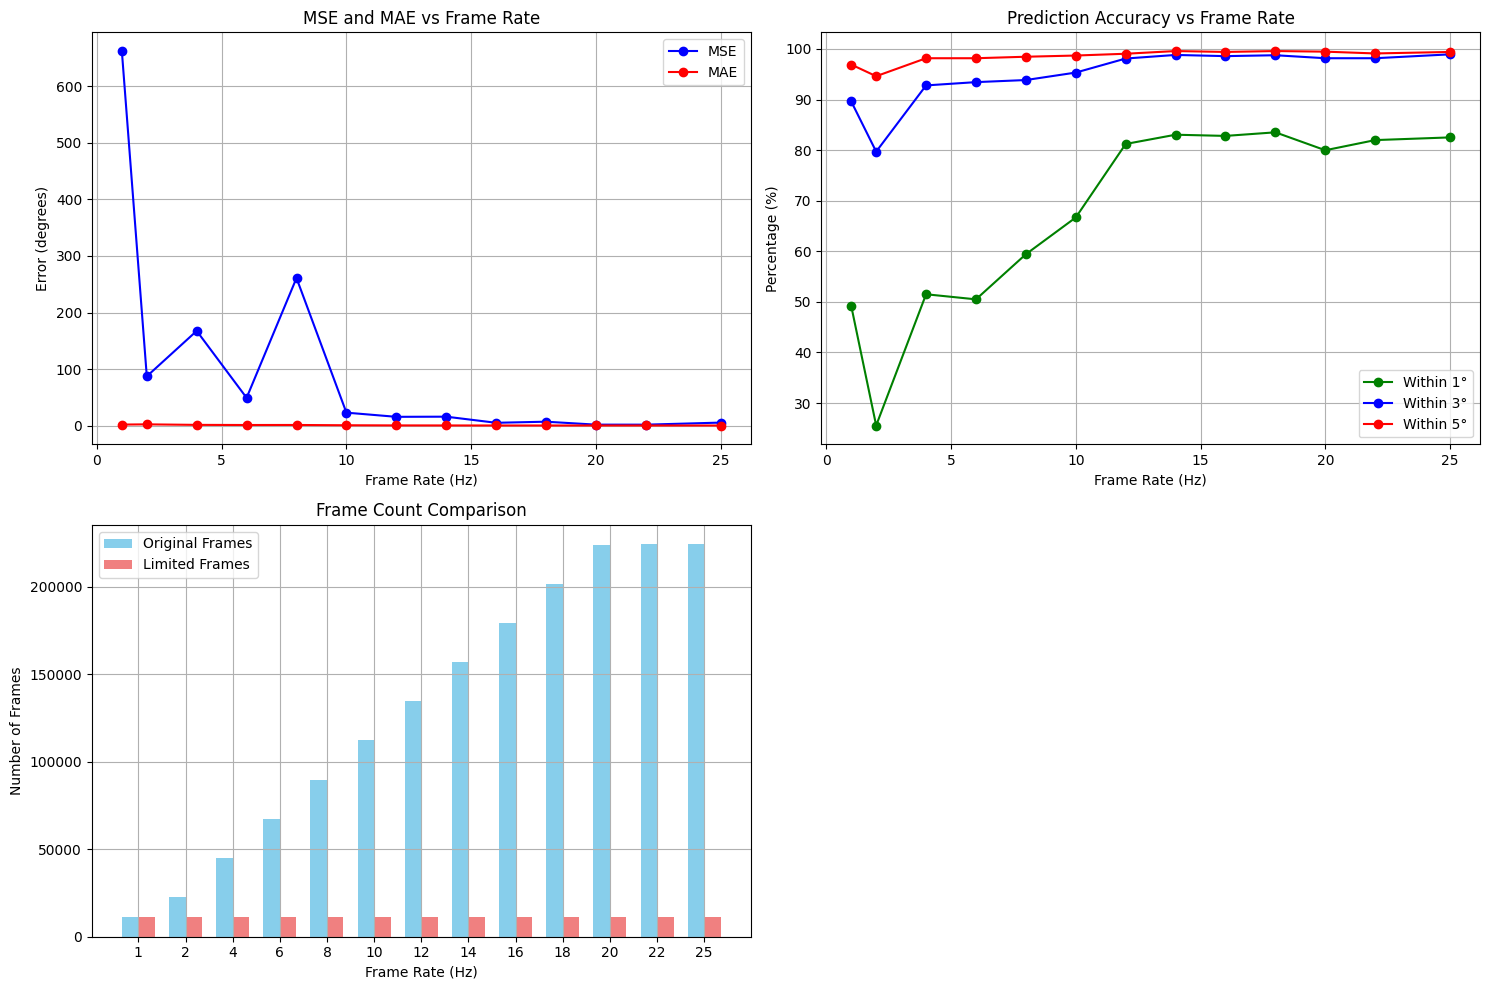


Numerical Results:

Frame Rate | Original Frames | Limited Frames | MSE | MAE | Within 1° | Within 3° | Within 5°
----------------------------------------------------------------------------------------------------
        1 |          11372 |         11241 | 661.74 |  2.35 |     49.2 |     89.6 |     96.9
        2 |          22566 |         11262 | 87.50 |  2.74 |     25.6 |     79.7 |     94.6
        4 |          45010 |         11280 | 167.69 |  1.81 |     51.5 |     92.8 |     98.2
        6 |          67425 |         11280 | 49.54 |  1.59 |     50.5 |     93.4 |     98.2
        8 |          89835 |         11280 | 261.03 |  1.65 |     59.4 |     93.9 |     98.5
       10 |         112239 |         11280 | 23.40 |  1.14 |     66.7 |     95.3 |     98.7
       12 |         134656 |         11280 | 16.03 |  0.89 |     81.2 |     98.1 |     99.1
       14 |         157028 |         11280 | 16.29 |  0.81 |     83.0 |     98.8 |     99.6
       16 |         179463 |         11280 | 

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import pandas as pd
import glob

class LimitedFramesDrivingDataset(Dataset):
    def __init__(self, csv_file, max_frames_per_video=60, transform=None):
        self.data = pd.read_csv(csv_file)
        filename = os.path.basename(csv_file)
        parent_dir = os.path.dirname(csv_file)
        self.frames_dir = os.path.join(parent_dir, f"{filename[:-4]}_frames")
        
        # Limit frames per video
        video_groups = self.data.groupby(['frame_idx']).first().reset_index()
        if len(video_groups) > max_frames_per_video:
            kept_frame_indices = video_groups['frame_idx'].iloc[:max_frames_per_video]
            self.data = self.data[self.data['frame_idx'].isin(kept_frame_indices)]
        
        if not os.path.exists(self.frames_dir):
            raise FileNotFoundError(f"Frames directory not found: {self.frames_dir}")
        
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data) if hasattr(self, 'data') else 0

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError(f"Index {idx} out of bounds for dataset of size {len(self)}")
            
        frame_idx = int(self.data.iloc[idx]['frame_idx'])
        frame_path = os.path.join(self.frames_dir, f"{frame_idx}.jpg")
        
        try:
            frame = Image.open(frame_path).convert('RGB')
        except Exception as e:
            raise Exception(f"Error loading image {frame_path}: {str(e)}")
        
        if self.transform:
            frame = self.transform(frame)
        
        row = self.data.iloc[idx]
        
        try:
            speed_value = float(row['speed'].strip('[]') if isinstance(row['speed'], str) else row['speed'])
            current_data = torch.tensor([
                speed_value,
                row['gyro_x'], row['gyro_y'], row['gyro_z'],
                row['accel_x'], row['accel_y'], row['accel_z'],
                row['velocity_x'], row['velocity_y'], row['velocity_z'],
                row['current_steering'],
            ], dtype=torch.float32)
            
            target = torch.tensor(row['future_steering'], dtype=torch.float32)
            
        except Exception as e:
            raise Exception(f"Error processing row {idx}: {str(e)}")
        
        return frame, current_data, target

def load_and_prepare_data(fps):
    """Load data for specific frame rate with frame limit"""
    data_dir = os.path.join(os.getcwd(), f'data_synced_{fps}hz')
    video_length_seconds = 60
    max_frames_per_video = video_length_seconds * 1
    
    csv_pattern = os.path.join(data_dir, '*.csv')
    csv_files = [f for f in glob.glob(csv_pattern) if 'combined_dataset.csv' not in f]
    
    if not csv_files:
        raise RuntimeError(f"No CSV files found for {fps}Hz!")
    
    datasets = []
    total_frames_before = 0
    total_frames_after = 0
    
    for csv_file in csv_files:
        try:
            original_data = pd.read_csv(csv_file)
            total_frames_before += len(original_data)
            
            dataset = LimitedFramesDrivingDataset(csv_file, max_frames_per_video=max_frames_per_video)
            total_frames_after += len(dataset)
            datasets.append(dataset)
        except Exception as e:
            continue

    if not datasets:
        raise RuntimeError(f"No datasets were successfully loaded for {fps}Hz!")

    print(f"\nFrame reduction summary for {fps}Hz:")
    print(f"Total frames before limiting: {total_frames_before}")
    print(f"Total frames after limiting: {total_frames_after}")
    print(f"Reduction: {((total_frames_before - total_frames_after) / total_frames_before * 100):.1f}%")

    full_dataset = ConcatDataset(datasets)
    total_size = len(full_dataset)

    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return (train_loader, val_loader, test_loader), total_frames_before, total_frames_after

frame_rates = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 25]
results = {
    'mse': [],
    'mae': [],
    'within_1_deg': [],
    'within_3_deg': [],
    'within_5_deg': [],
    'frames_before': [],
    'frames_after': []
}

def train_and_evaluate(fps, train_loader, val_loader, test_loader):
    print(f"\nTraining and evaluating model for {fps}Hz data...")
    
    model = SteeringAngleCNN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    model, train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=50,
        patience=8
    )
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, sensor_data, target_angle in test_loader:
            images = images.to(device)
            sensor_data = sensor_data.to(device)
            target_angle = target_angle.to(device).view(-1, 1)

            outputs = model(images, sensor_data)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(target_angle.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    metrics = {
        'mse': float(np.mean((all_preds - all_targets) ** 2)),
        'mae': float(np.mean(np.abs(all_preds - all_targets))),
        'within_1_deg': float(np.mean(np.abs(all_preds - all_targets) < 1.0) * 100),
        'within_3_deg': float(np.mean(np.abs(all_preds - all_targets) < 3.0) * 100),
        'within_5_deg': float(np.mean(np.abs(all_preds - all_targets) < 5.0) * 100)
    }
    
    torch.save(model.state_dict(), f'v4_CNN_{fps}hz.pth')
    print(f"Model saved to 'v4_CNN_{fps}hz.pth'")
    
    return metrics

# Training and evaluation loop
for fps in frame_rates:
    try:
        print(f"\n=== Processing {fps}Hz data ===")
        (train_loader, val_loader, test_loader), frames_before, frames_after = load_and_prepare_data(fps)
        
        results['frames_before'].append(frames_before)
        results['frames_after'].append(frames_after)
        
        metrics = train_and_evaluate(fps, train_loader, val_loader, test_loader)
        for key in results:
            if key not in ['frames_before', 'frames_after']:
                results[key].append(metrics[key])
                
    except Exception as e:
        print(f"Error processing {fps}Hz: {str(e)}")
        for key in results:
            results[key].append(None)

# Create plots
plt.figure(figsize=(15, 10))

# Plot 1: MSE and MAE
plt.subplot(2, 2, 1)
plt.plot(frame_rates, results['mse'], 'b-o', label='MSE')
plt.plot(frame_rates, results['mae'], 'r-o', label='MAE')
plt.xlabel('Frame Rate (Hz)')
plt.ylabel('Error (degrees)')
plt.title('MSE and MAE vs Frame Rate')
plt.grid(True)
plt.legend()

# Plot 2: Accuracy within degree thresholds
plt.subplot(2, 2, 2)
plt.plot(frame_rates, results['within_1_deg'], 'g-o', label='Within 1°')
plt.plot(frame_rates, results['within_3_deg'], 'b-o', label='Within 3°')
plt.plot(frame_rates, results['within_5_deg'], 'r-o', label='Within 5°')
plt.xlabel('Frame Rate (Hz)')
plt.ylabel('Percentage (%)')
plt.title('Prediction Accuracy vs Frame Rate')
plt.grid(True)
plt.legend()

# Plot 3: Frame counts comparison
plt.subplot(2, 2, 3)
x = np.arange(len(frame_rates))
width = 0.35

plt.bar(x - width/2, results['frames_before'], width, label='Original Frames', color='skyblue')
plt.bar(x + width/2, results['frames_after'], width, label='Limited Frames', color='lightcoral')
plt.xlabel('Frame Rate (Hz)')
plt.ylabel('Number of Frames')
plt.title('Frame Count Comparison')
plt.xticks(x, frame_rates)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('frame_rate_comparison_fair.png')
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("\nFrame Rate | Original Frames | Limited Frames | MSE | MAE | Within 1° | Within 3° | Within 5°")
print("-" * 100)
for i, fps in enumerate(frame_rates):
    print(f"{fps:9d} | {results['frames_before'][i]:14d} | {results['frames_after'][i]:13d} | "
          f"{results['mse'][i]:5.2f} | {results['mae'][i]:5.2f} | "
          f"{results['within_1_deg'][i]:8.1f} | {results['within_3_deg'][i]:8.1f} | "
          f"{results['within_5_deg'][i]:8.1f}")